# Model training

In [42]:
import pandas as pd
import os
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import LeaveOneOut, LeavePOut, RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import PredictionErrorDisplay
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from collections.abc import MutableMapping

from scipy.stats import lognorm, uniform, randint

RS = 42

# Utility functions

In [43]:
# Read full DF if it is present, merge all other DFs instead
def load_csv():
    if ('full_df.csv' not in os.listdir()):
        df_list = []

        df_paths = [path for path in os.listdir() if path.lower().endswith('.csv') and path != "full_df.csv"]
        for path in df_paths:
            df = pd.read_csv(path, index_col=['pole_id', 'height_id'])
            df_list.append(df)

        full_df = pd.concat(df_list, axis=1, join='inner').reset_index()
        full_df.to_csv('full_df.csv')

    else:
        full_df = pd.read_csv('full_df.csv').drop('Unnamed: 0', axis=1)
        
    return full_df

def dict_product(dicts):
    return list(dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

def flatten(dictionary, parent_key='', separator='_'):
    items = []
    for key, value in dictionary.items():
        new_key = key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

# Loading the data

In [44]:
full_df = load_csv()
X, y_surf, y_mid, y_int, y_diam, y_sdepth = full_df.iloc[:,2:-6], full_df.iloc[:,-6], full_df.iloc[:,-5], full_df.iloc[:,-4], full_df.iloc[:,-2], full_df.iloc[:,-1]

# Experiments - pole surface

## Experiment #1: Scaling + linear model

The most naïve approach is to just apply scaling to the dataset variables, and then training some linear model on top of this.

In [50]:
def run_exp(exp_name, target, pipe, param_grid, randomize=False, rs_iters=50, random_state=42, mae_plot_padding = True):
    # Directory for plots
    if not os.path.exists(f'plots/{exp_name}'):
        os.mkdir(f'plots/{exp_name}')
    
    # Create and fit the model. Find best linear model with grid search, and validate using 10 repetitions of 5-fold CV
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
    if not randomize:
        gs = GridSearchCV(pipe, param_grid, cv=cv, scoring=['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2'], refit='neg_mean_absolute_error', n_jobs=-1)
    else:
        gs = RandomizedSearchCV(pipe, param_grid, cv=cv, scoring=['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2'], refit='neg_mean_absolute_error', random_state=random_state, n_iter=rs_iters, n_jobs=-1, verbose=3)
        
    gs.fit(X, target)
    
    # Show plots and statistics of the best model
    print(f'The best estimator is: {gs.best_estimator_}')
    best_mae_idx = np.where(gs.cv_results_["rank_test_neg_mean_absolute_error"] == 1)[0][0]
    print(f'Mean absolute error of this model: {gs.cv_results_["mean_test_neg_mean_absolute_error"][best_mae_idx]:.2f} ± {gs.cv_results_["std_test_neg_mean_absolute_error"][best_mae_idx]:.2f}')
    
    # Plot histogram of MAE and R2 estimates
    mae_estimates = [-gs.cv_results_[f"split{i}_test_neg_mean_absolute_error"][best_mae_idx] for i in range(50)]
    r2_estimates = [gs.cv_results_[f"split{i}_test_r2"][best_mae_idx] for i in range(50)]
    _, axes = plt.subplots(1,2,figsize=(14,7))
    axes[0].plot(range(len(mae_estimates)), mae_estimates)
    axes[1].plot(range(len(mae_estimates)), r2_estimates)
    axes[0].title.set_text("MAE on all splits")
    axes[1].title.set_text("$R^2$ on all splits")
    axes[0].set_xlabel("# split")
    axes[1].set_xlabel("# split")
    axes[0].set_ylabel("MAE")
    axes[1].set_ylabel("$R^2$")
    padding = 100 if mae_plot_padding else 0
    axes[0].set_ylim([0,np.max(mae_estimates) + padding])
    axes[1].set_ylim([-12,12])
    axes[1].axhline(1, linestyle="--", c='black')
    axes[1].axhline(-1, linestyle="--", c='black')
    plt.savefig(f'plots/{exp_name}/metric_values_splits.svg')
    
    # Plot actual vs. predicted values
    _, ax = plt.subplots(figsize=(7,7))
    display = PredictionErrorDisplay.from_predictions(y_true=target, y_pred=gs.predict(X), ax=ax, kind="actual_vs_predicted")
    ax.title.set_text(f'$R^2$ estimate: {gs.cv_results_["mean_test_r2"][best_mae_idx]:.2f} ± {gs.cv_results_["std_test_r2"][best_mae_idx]:.2f}\nMAE estimate: {gs.cv_results_["mean_test_neg_mean_absolute_error"][best_mae_idx]:.2f} ± {gs.cv_results_["std_test_neg_mean_absolute_error"][best_mae_idx]:.2f}')
    plt.savefig(f'plots/{exp_name}/prediction_error.svg')
    
    feature_names = gs.best_estimator_[:-1].get_feature_names_out()
    
    # Plot largest coefficients
    coefs = pd.DataFrame(
        gs.best_estimator_[-1].coef_,
        columns=["Coefficients"],
        index=feature_names,
    )

    coefs['abs_coef'] = coefs['Coefficients'].abs()
    coefs = coefs.sort_values(by='abs_coef', axis=0, ascending=False).head(20).drop('abs_coef', axis=1).iloc[::-1]

    coefs.plot.barh(figsize=(9, 7))
    plt.title("Best model")
    plt.axvline(x=0, color=".5")
    plt.xlabel("Raw coefficient values")
    plt.subplots_adjust(left=0.3)
    plt.savefig(f'plots/{exp_name}/coeff_values.svg')
    
    # Plot coefficient variance
    cv_model = cross_validate(
        gs.best_estimator_,
        X,
        target,
        cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state),
        return_estimator=True,
        n_jobs=2
    )

    var_coefs = pd.DataFrame(
        [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names
    )
    
    plt.figure(figsize=(9, len(coefs) * 0.8))
    sns.stripplot(data=var_coefs[coefs.index.to_list()], orient="h", palette="dark:k", alpha=0.5, order=coefs.index.to_list()[::-1])
    sns.boxplot(data=var_coefs[coefs.index.to_list()], orient="h", color="cyan", saturation=0.5, whis=10, order=coefs.index.to_list()[::-1])
    plt.axvline(x=0, color=".5")
    plt.title("Coefficient variability (most important coefficients)")
    plt.subplots_adjust(left=0.3)
    plt.savefig(f'plots/{exp_name}/coeff_variability.svg')
    
    
    # Save CV results to DataFrame
    df_results = pd.DataFrame(gs.cv_results_)
    df_results.to_csv(f'results/{exp_name}.csv')

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -890.14 ± 217.80


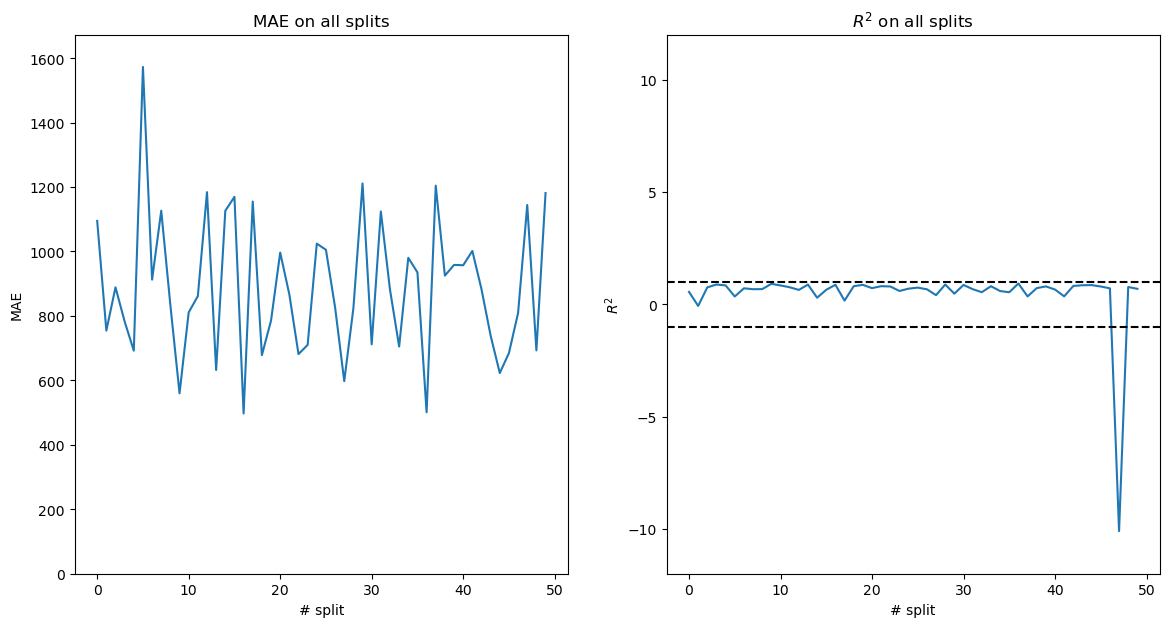

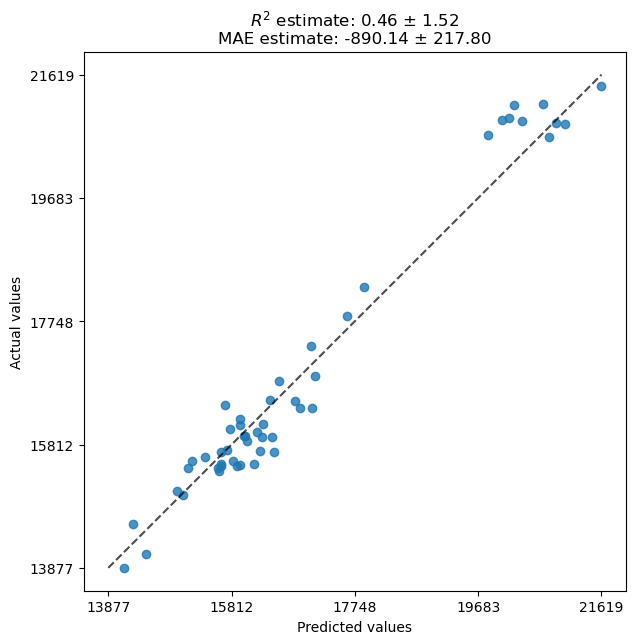

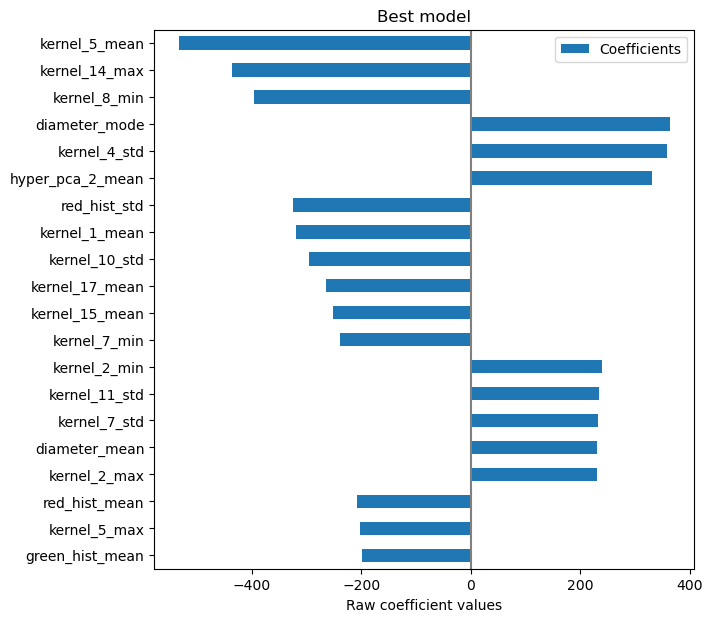

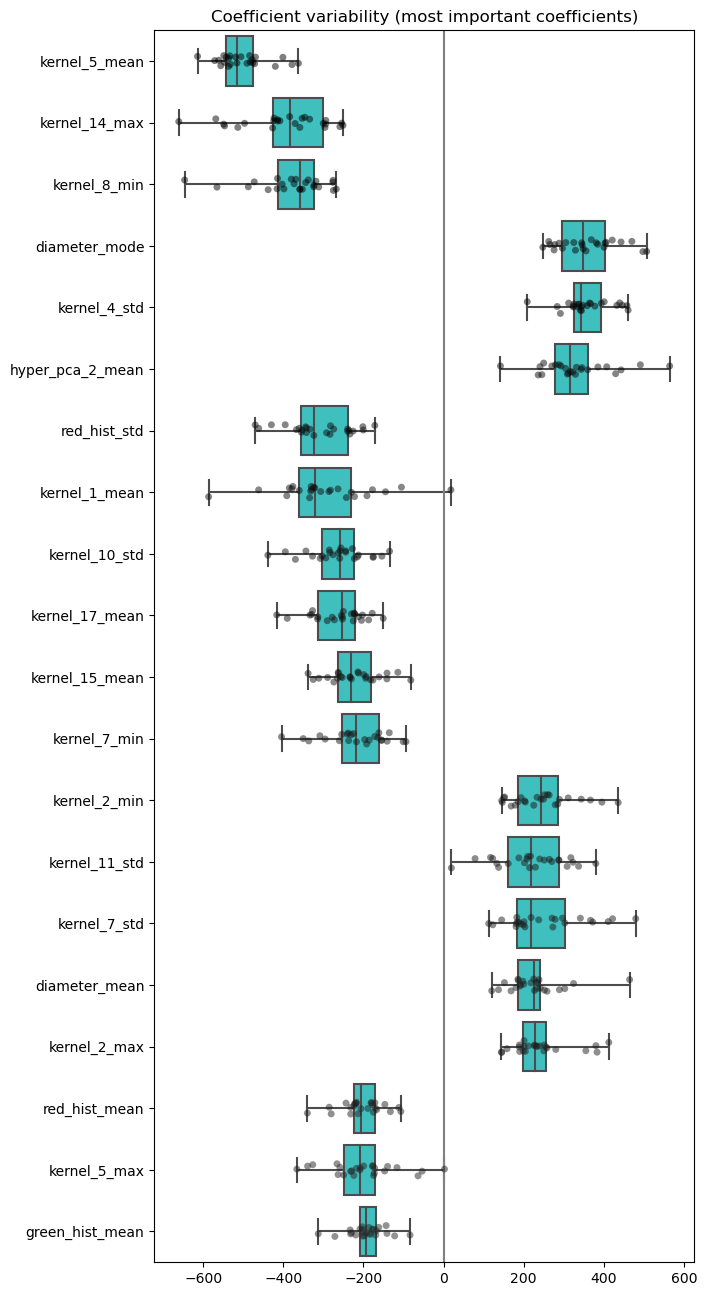

In [30]:
pipeline_exp1 = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])

params_exp1 = [
    {'model': [LinearRegression()]},
    {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("surface_scale_linear", y_surf, pipeline_exp1, params_exp1, random_state=RS)

## Experiment #2: Scaling + dimensionality reduction + linear model

As the preliminary analysis has shown, this dataset has 89 predictor variables, but only 50 samples. This high dimensionality may lead to overfitting issues, and therefore it could be interesting to try different dimensionality reduction techniques.

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dims', PCA(n_components=27)),
                ('model', LinearRegression())])
Mean absolute error of this model: -848.35 ± 213.87


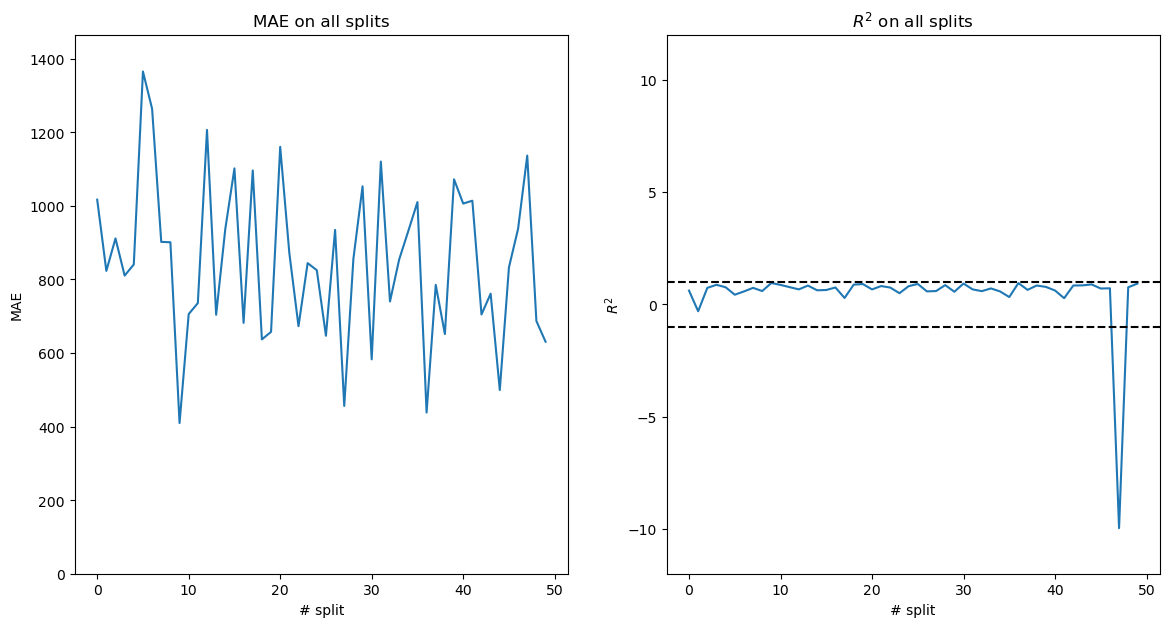

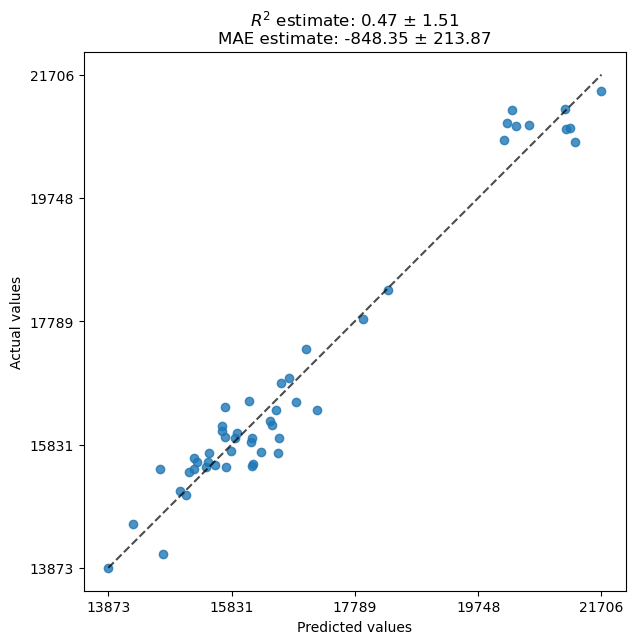

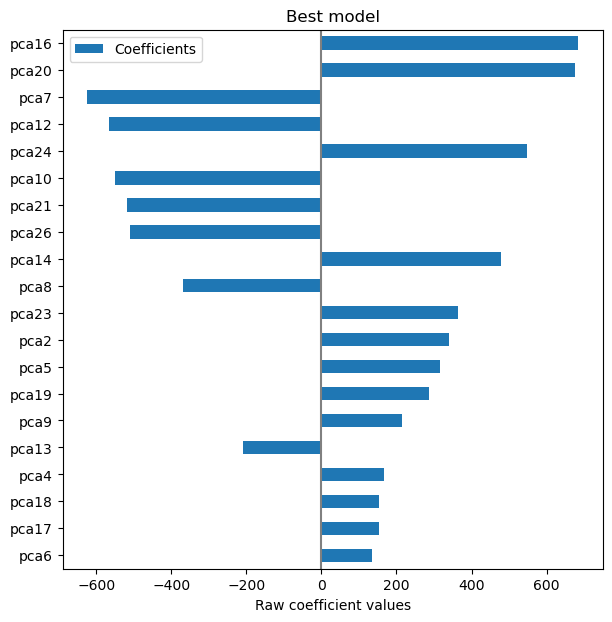

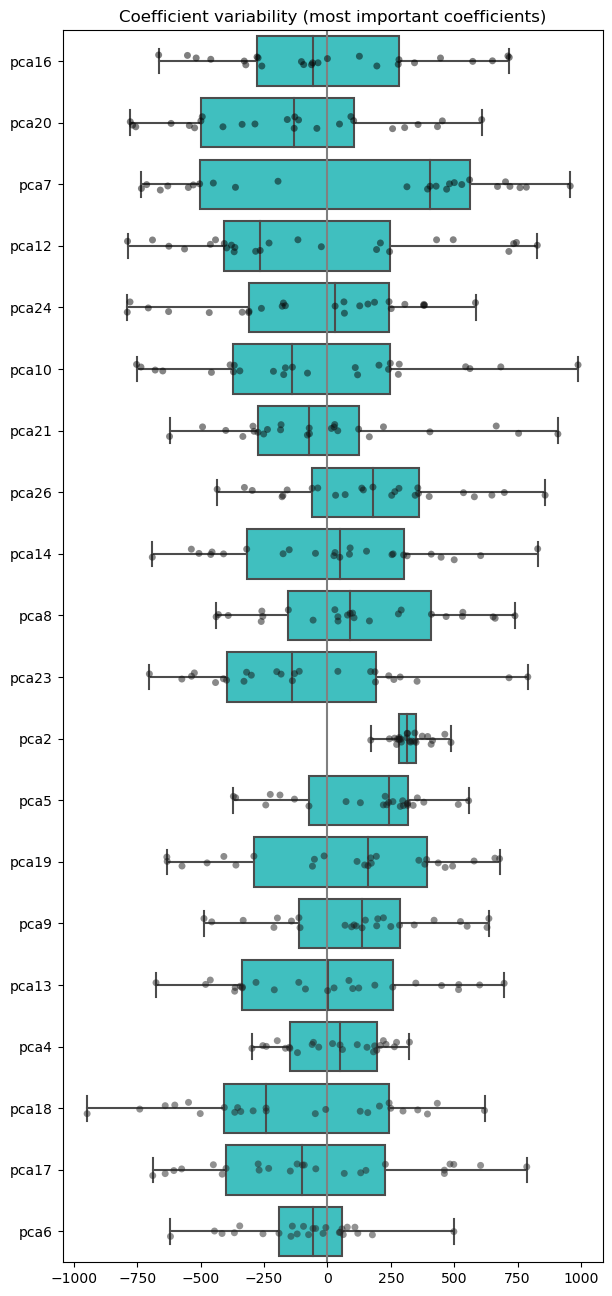

In [31]:
pipeline_exp2 = Pipeline([('scaler', StandardScaler()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp2 = [
    {'reduce_dims__n_components': randint(1,30), 'model': [LinearRegression()]},
    {'reduce_dims__n_components': randint(1,30), 'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'reduce_dims__n_components': randint(1,30), 'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'reduce_dims__n_components': randint(1,30), 'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("surface_scale_reduce_linear", y_surf, pipeline_exp2, params_exp2, randomize=True, random_state=RS)

## Experiment #3: Scaling + feature selection + linear model

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 SelectKBest(k=74,
                             score_func=<function f_regression at 0x0000014FA6996C10>)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -917.53 ± 253.10


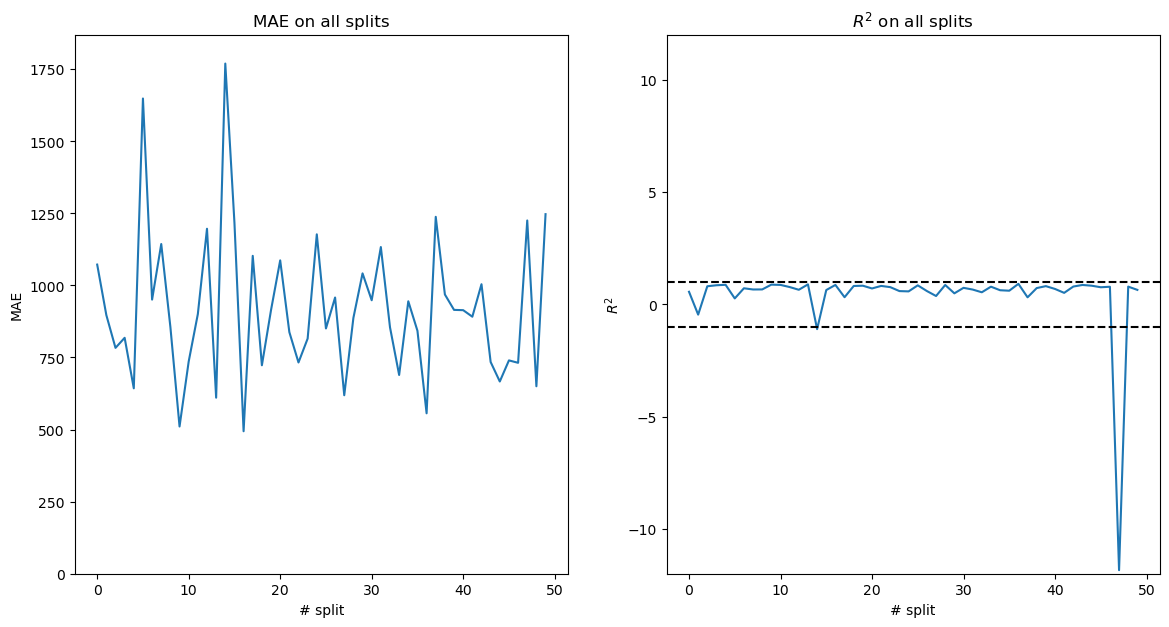

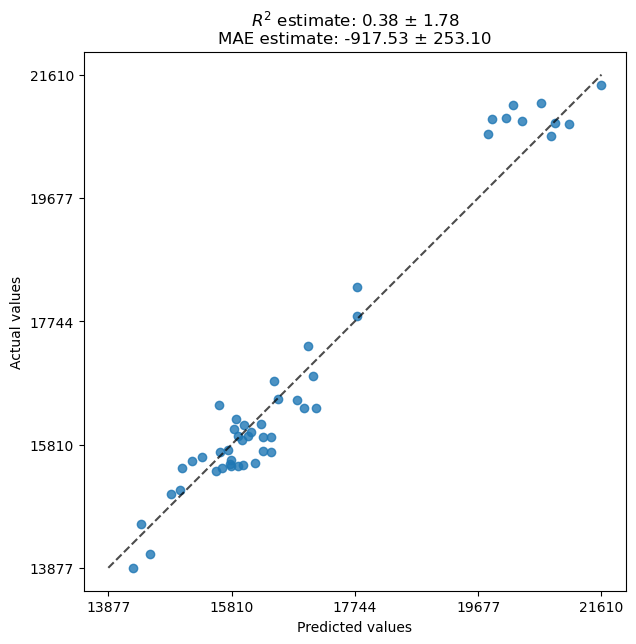

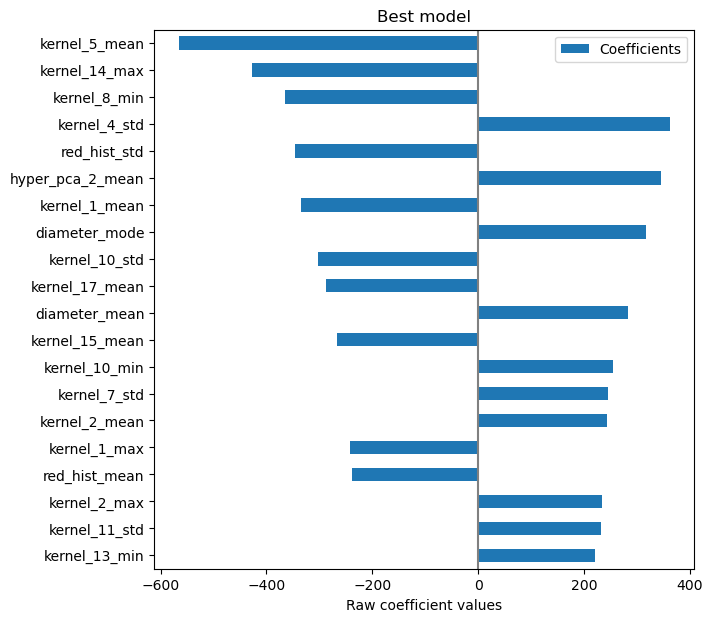

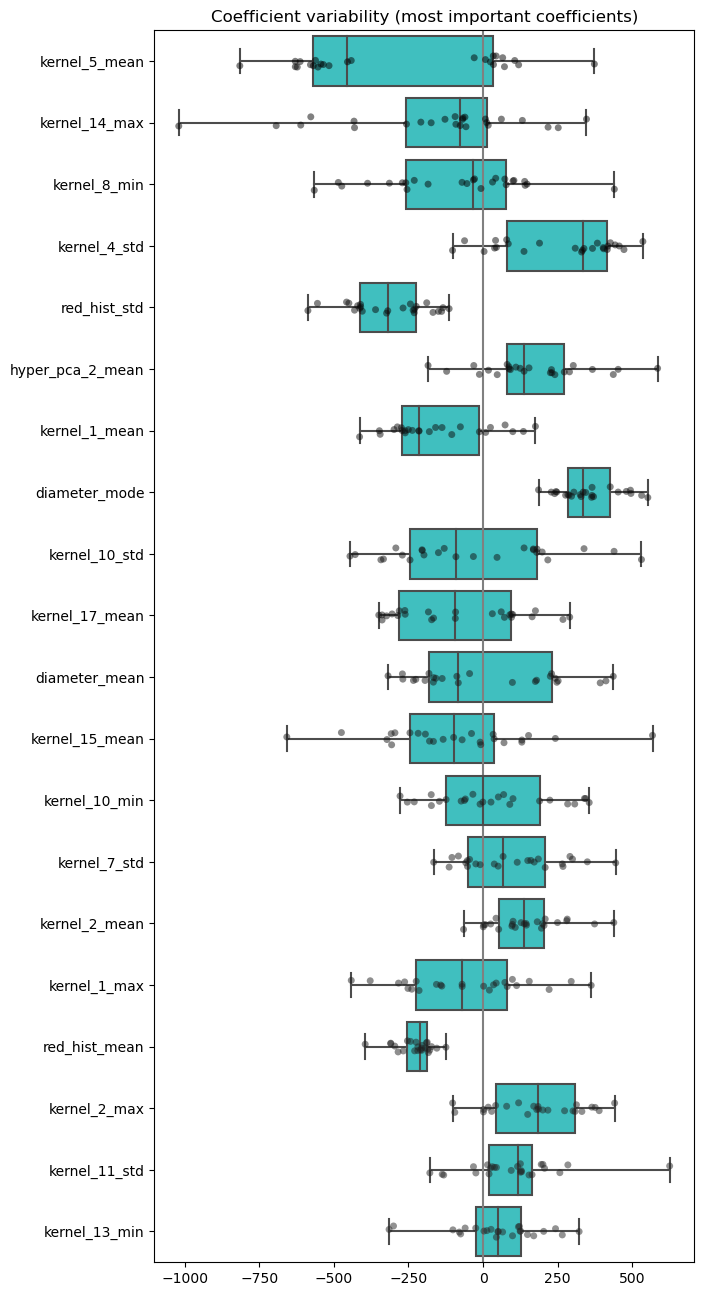

In [32]:
pipeline_exp3 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('model', LinearRegression())])

params_exp3 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp3 = [flatten(params, parent_key=None) for params in dict_product(params_exp3)]

run_exp("surface_scale_select_linear", y_surf, pipeline_exp3, params_exp3, randomize=True, random_state=RS)

## Experiment #4: Scaling + feature selection + dimensionality reduction + linear model

Fitting 50 folds for each of 200 candidates, totalling 10000 fits


C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1850 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\pipeline.py", lin

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 RFE(estimator=LinearRegression(), n_features_to_select=77)),
                ('reduce_dims', PCA(n_components=25)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -879.68 ± 182.49


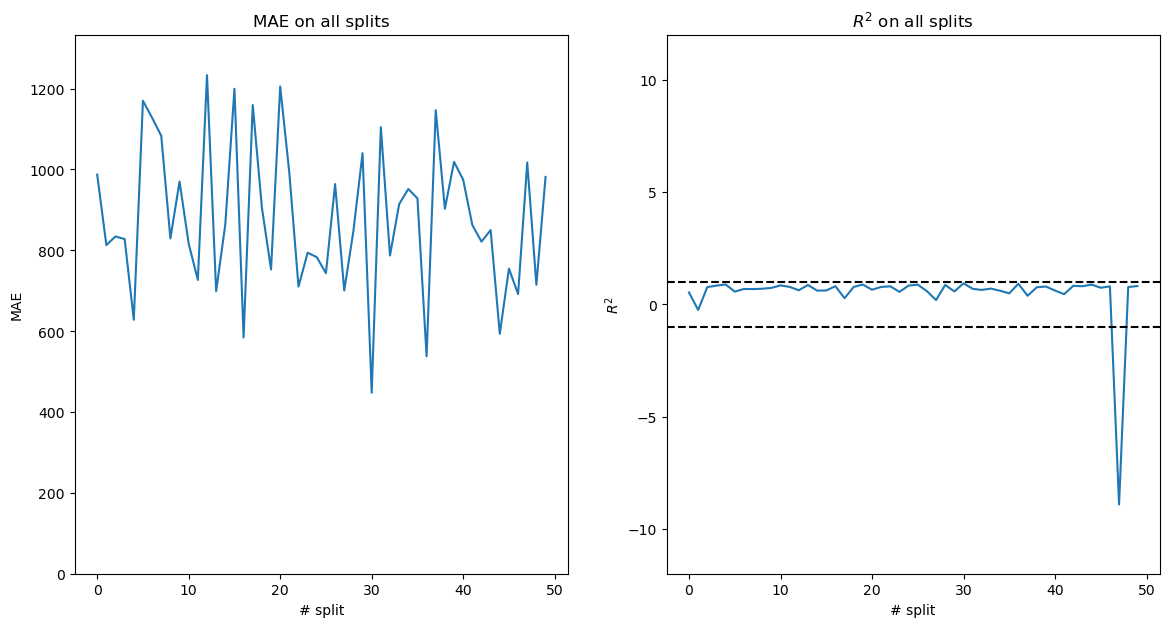

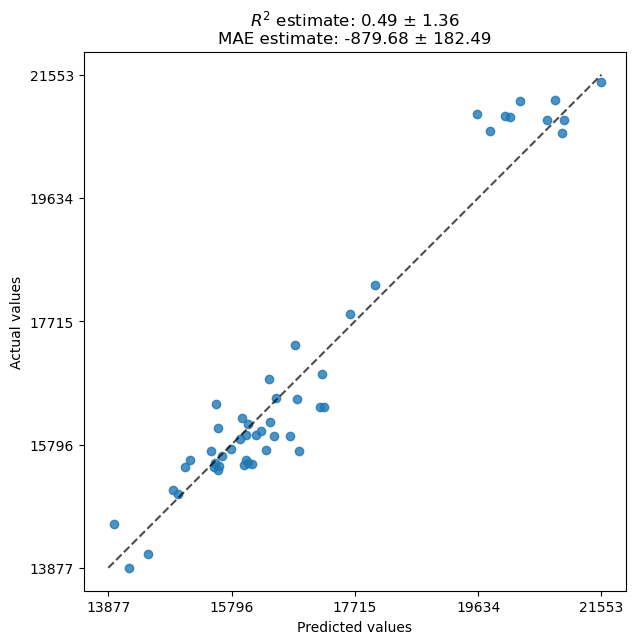

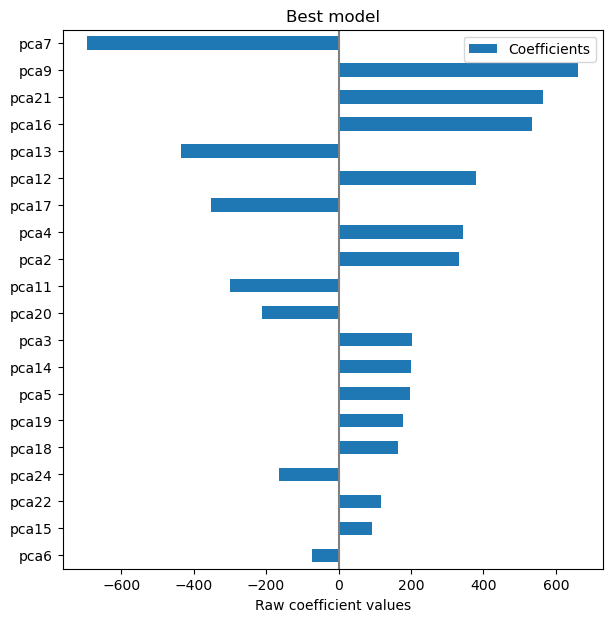

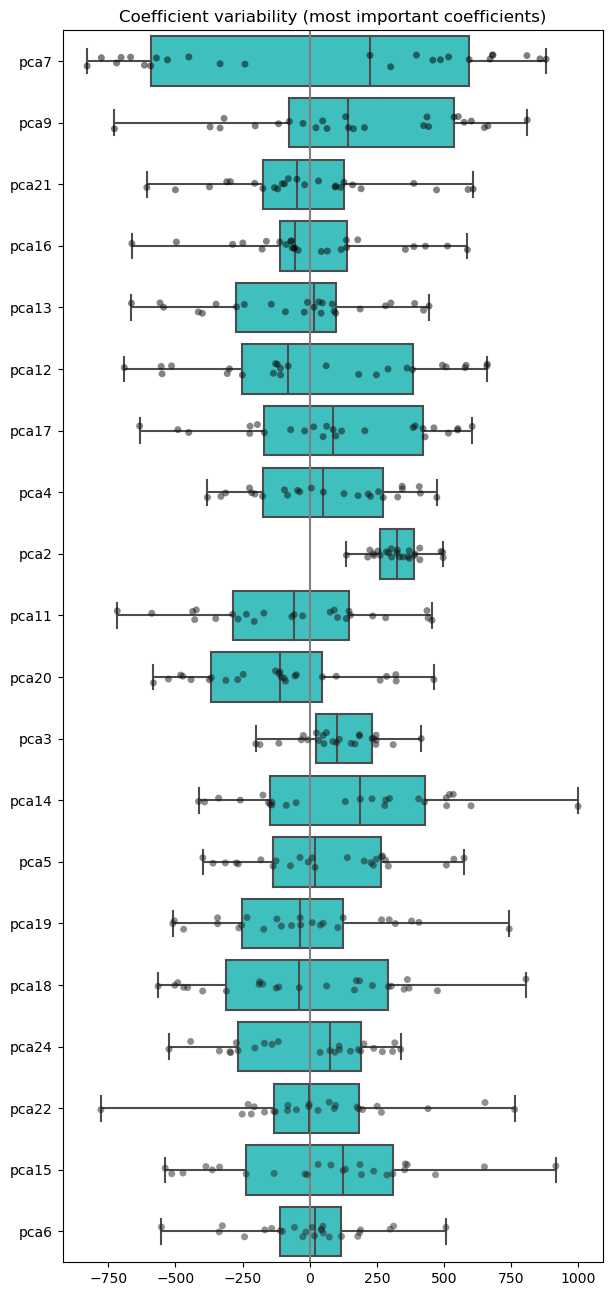

In [33]:
pipeline_exp4 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp4 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'dims': [
        {'reduce_dims__n_components': randint(1,30)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp4 = [flatten(params, parent_key=None) for params in dict_product(params_exp4)]
run_exp("surface_scale_select_reduce_linear", y_surf, pipeline_exp4, params_exp4, randomize=True, rs_iters=200, random_state=RS)

# Experiments - pole middle

## Experiment #1: Scaling + linear model

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -520.53 ± 150.35


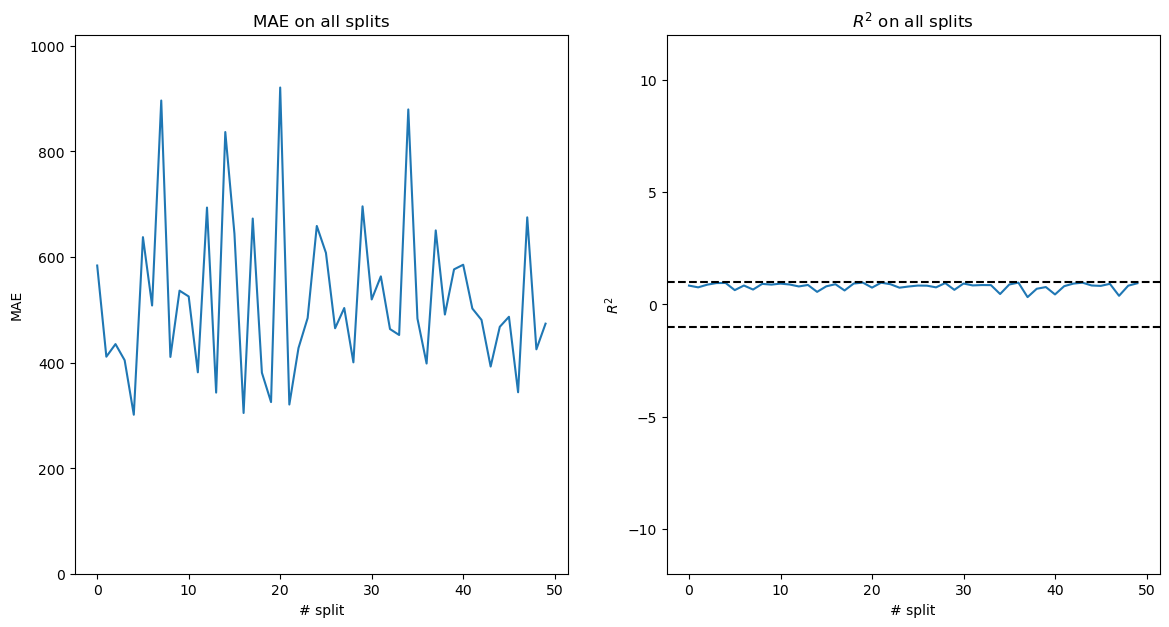

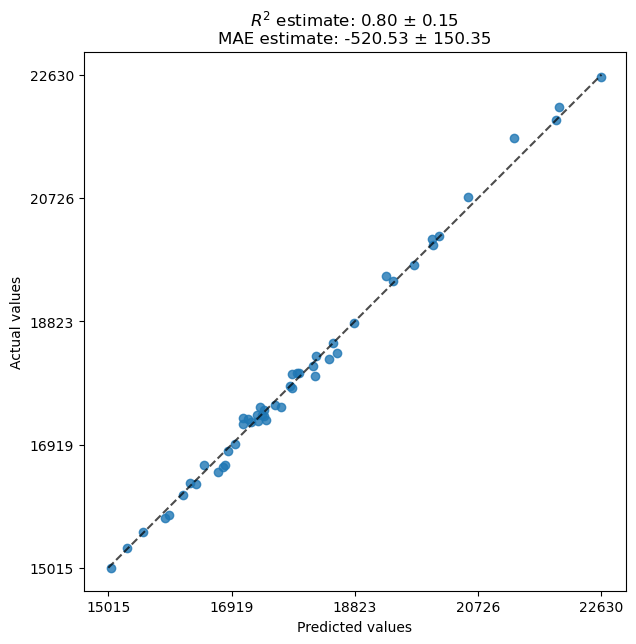

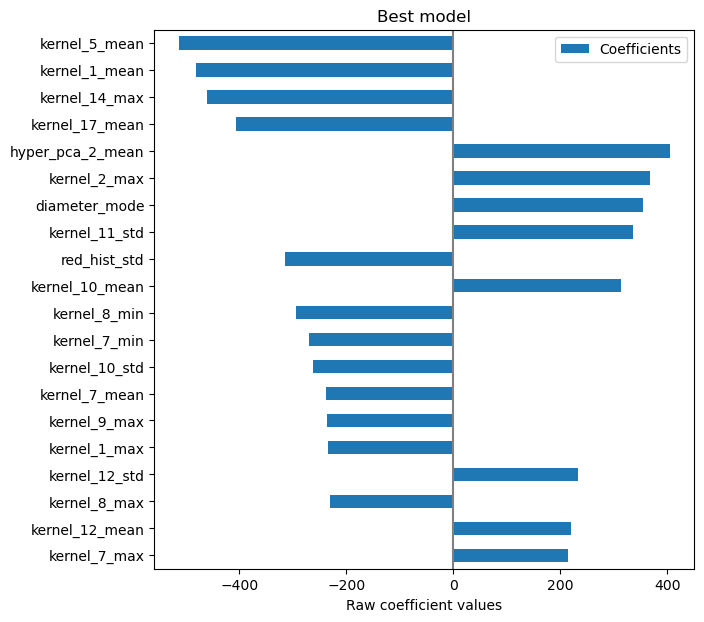

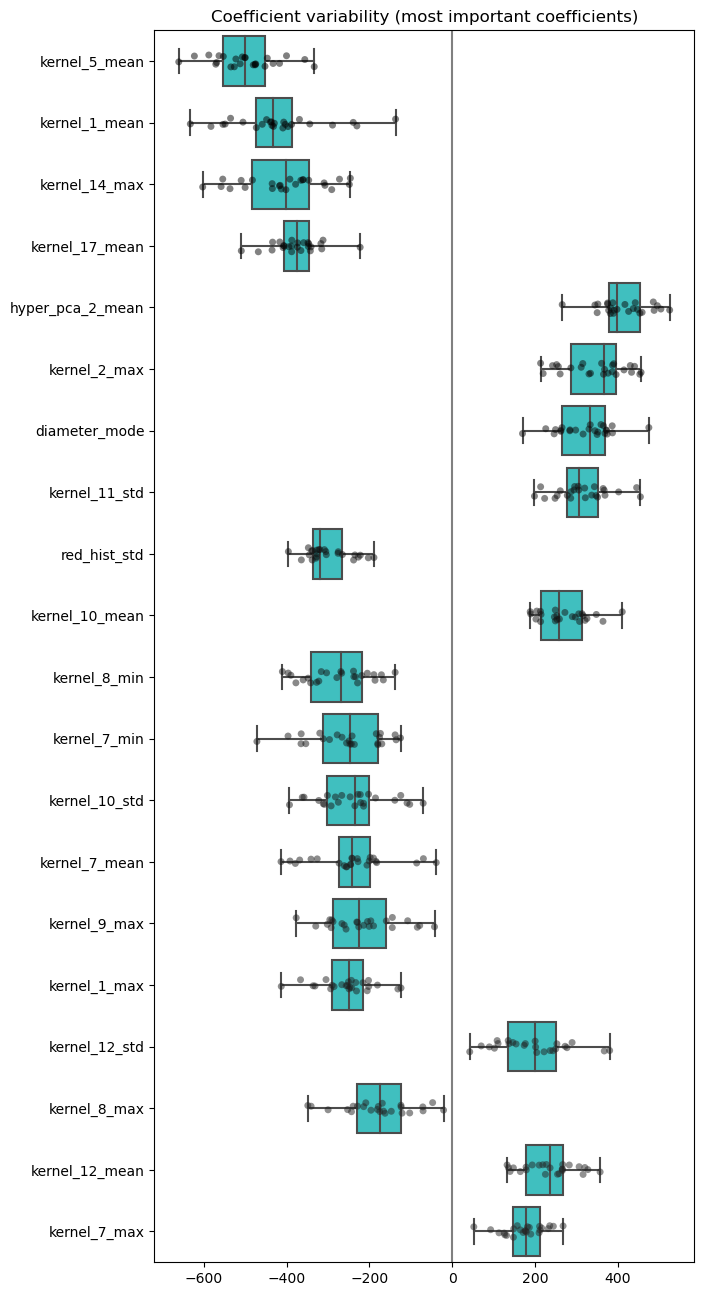

In [34]:
pipeline_exp1 = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])

params_exp1 = [
    {'model': [LinearRegression()]},
    {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("middle_scale_linear", y_mid, pipeline_exp1, params_exp1, random_state=RS)

## Experiment #2: Scaling + dimensionality reduction + linear model

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dims', PCA(n_components=29)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -582.26 ± 173.88


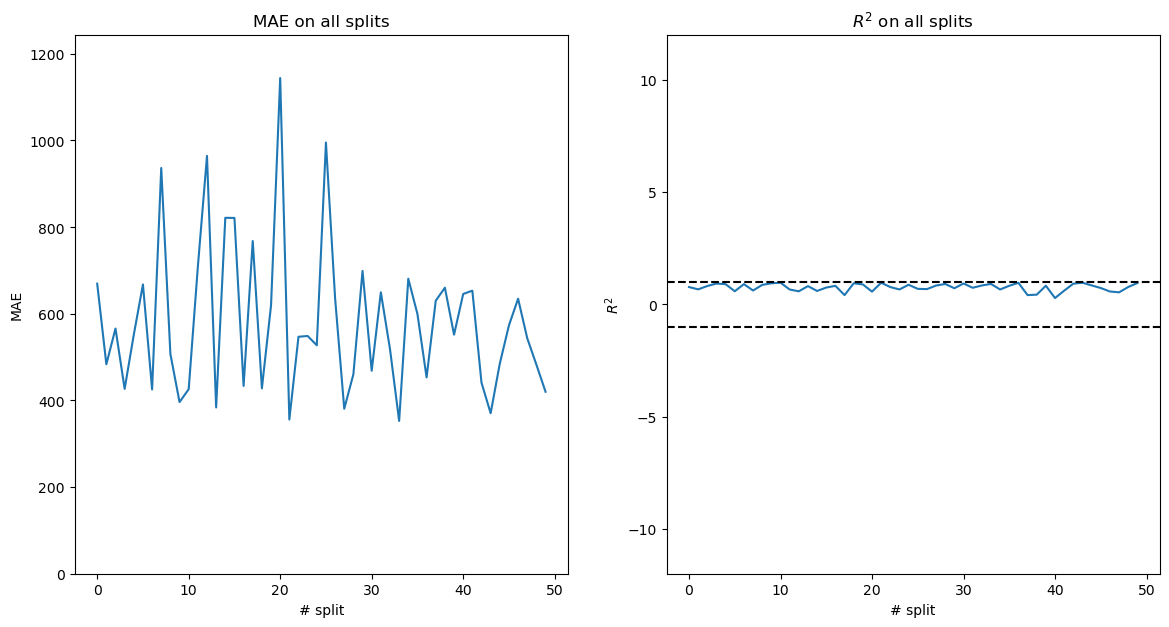

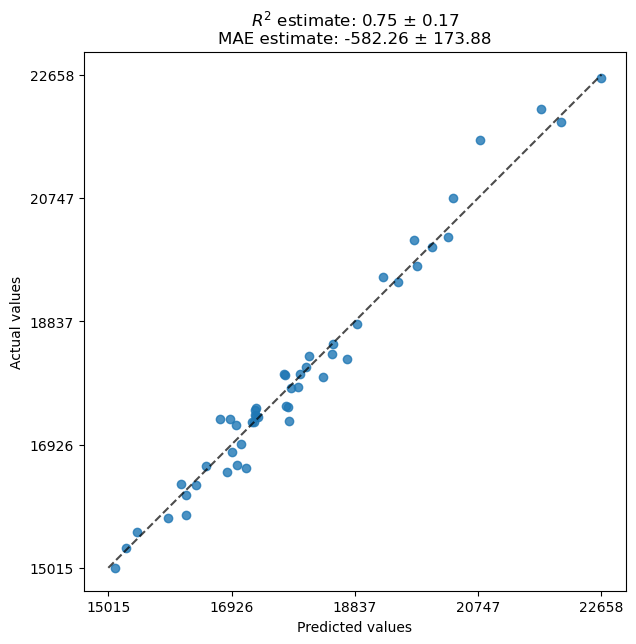

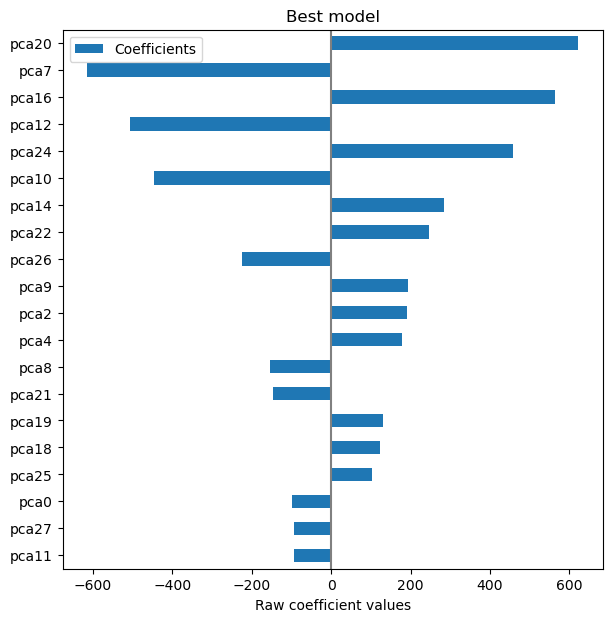

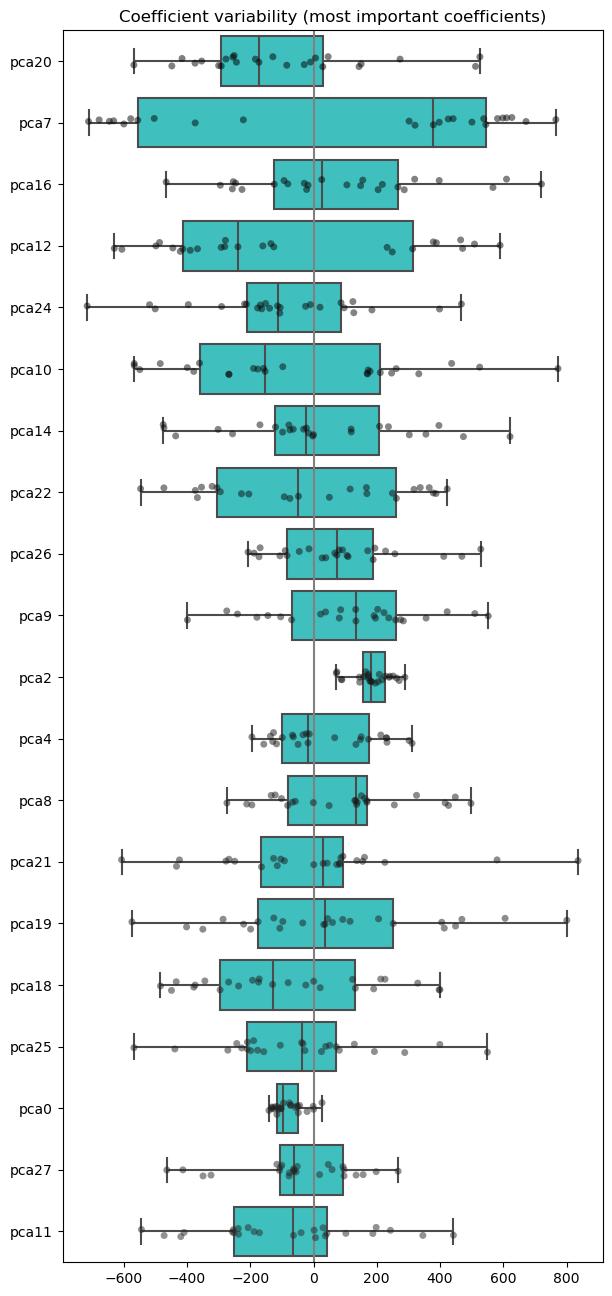

In [35]:
pipeline_exp2 = Pipeline([('scaler', StandardScaler()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp2 = [
    {'reduce_dims__n_components': randint(1,30), 'model': [LinearRegression()]},
    {'reduce_dims__n_components': randint(1,30), 'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'reduce_dims__n_components': randint(1,30), 'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'reduce_dims__n_components': randint(1,30), 'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("middle_scale_reduce_linear", y_mid, pipeline_exp2, params_exp2, randomize=True, random_state=RS)

## Experiment #3: Scaling + feature selection + linear model

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 RFE(estimator=LinearRegression(), n_features_to_select=63)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -536.61 ± 145.66


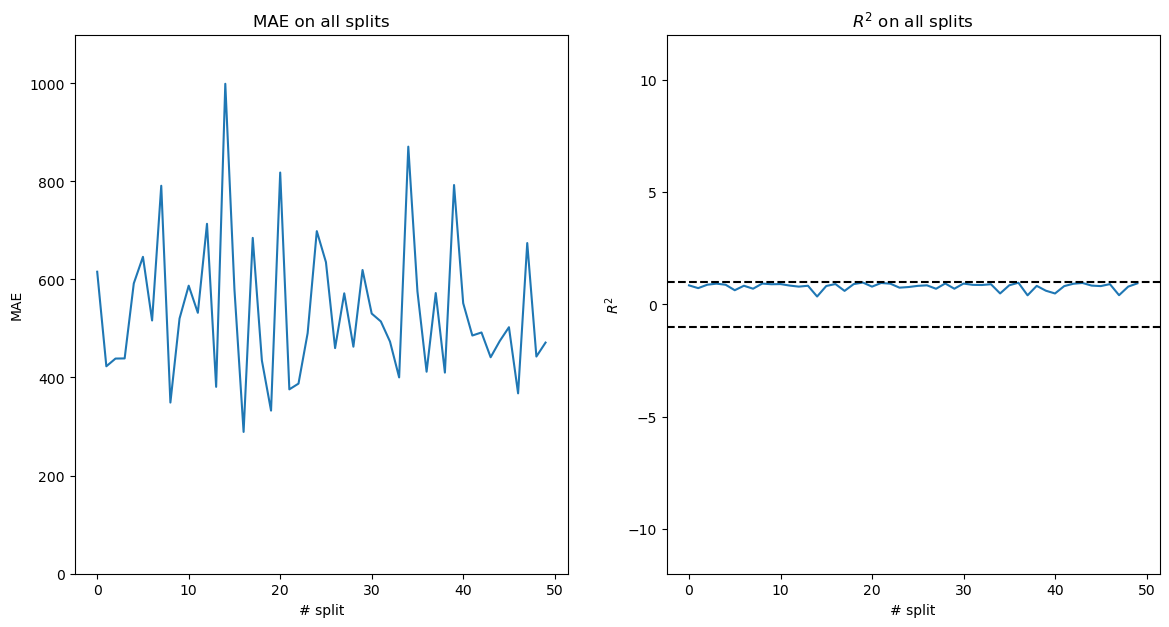

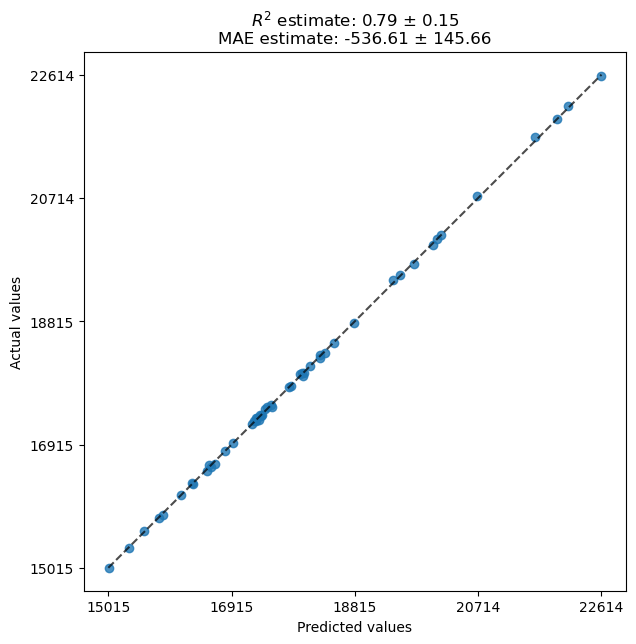

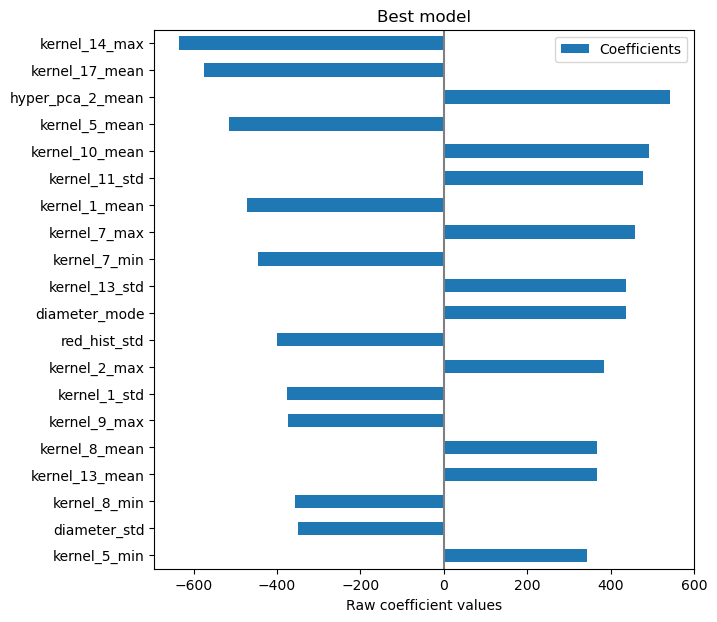

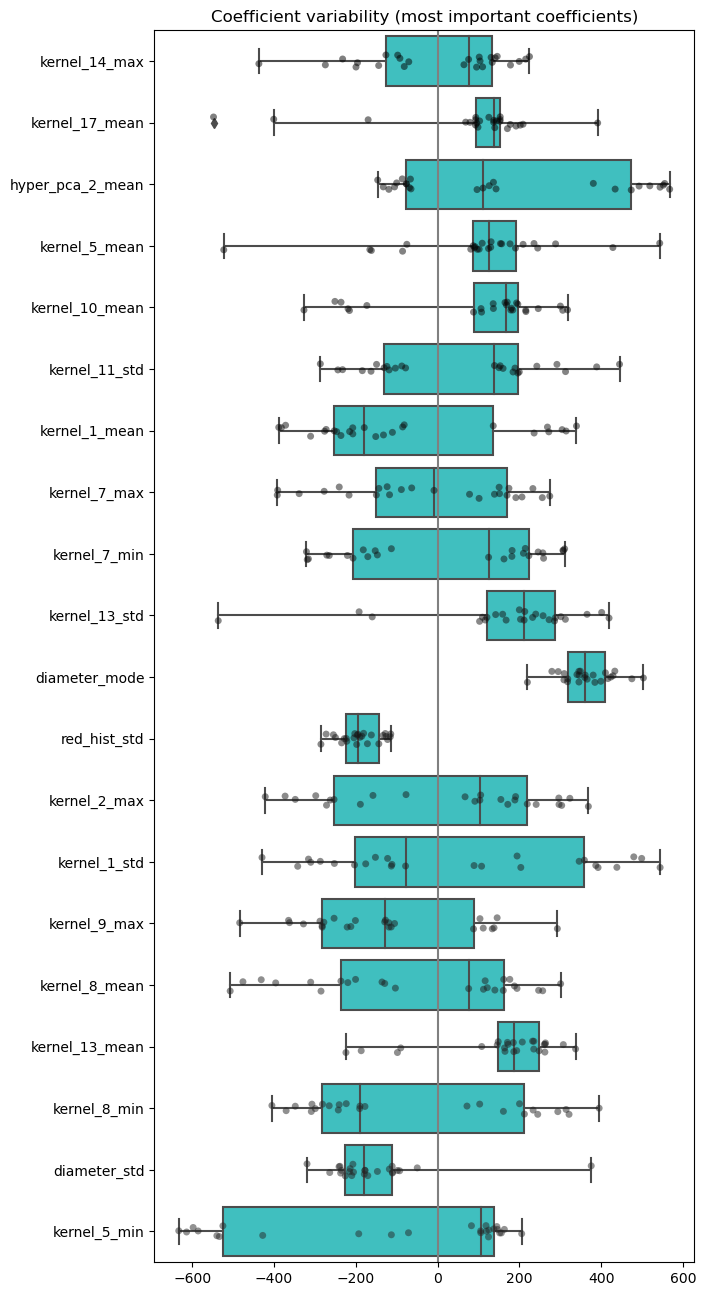

In [36]:
pipeline_exp3 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('model', LinearRegression())])

params_exp3 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp3 = [flatten(params, parent_key=None) for params in dict_product(params_exp3)]

run_exp("middle_scale_select_linear", y_mid, pipeline_exp3, params_exp3, randomize=True, random_state=RS)

## Experiment #4: Scaling + feature selection + dimensionality reduction + linear model

Fitting 50 folds for each of 200 candidates, totalling 10000 fits


C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1850 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\pipeline.py", lin

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 RFE(estimator=LinearRegression(), n_features_to_select=62)),
                ('reduce_dims', PCA(n_components=28)),
                ('model',
                 LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=42))])
Mean absolute error of this model: -549.61 ± 165.33


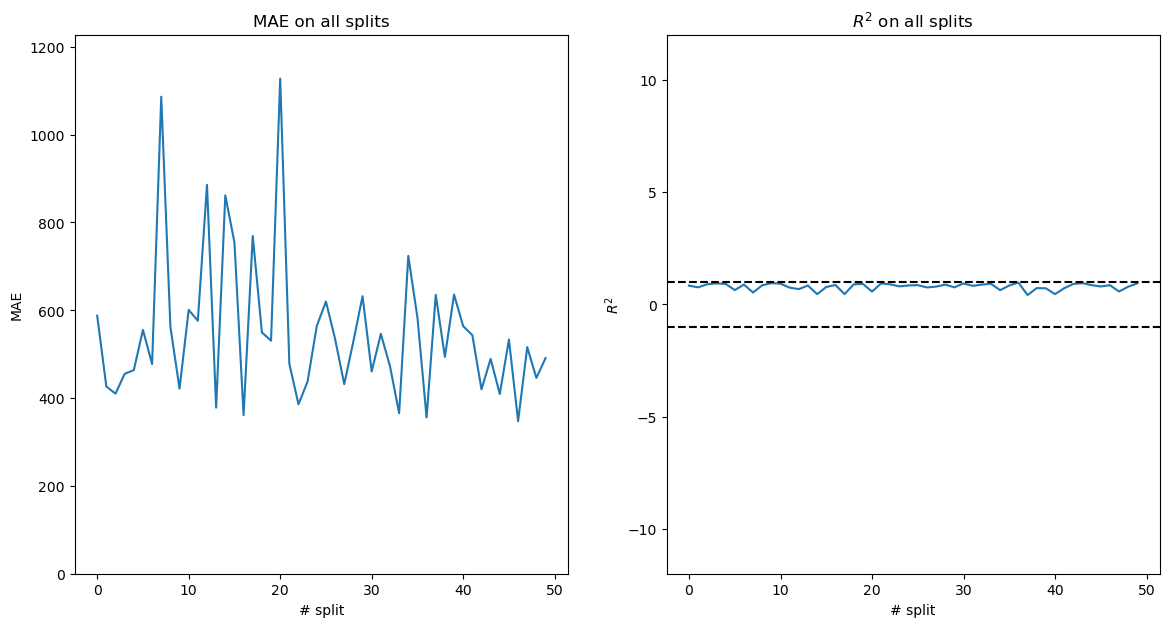

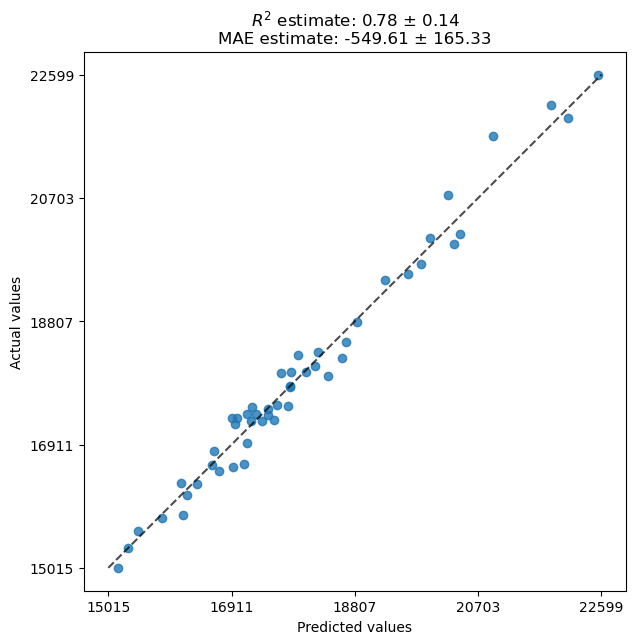

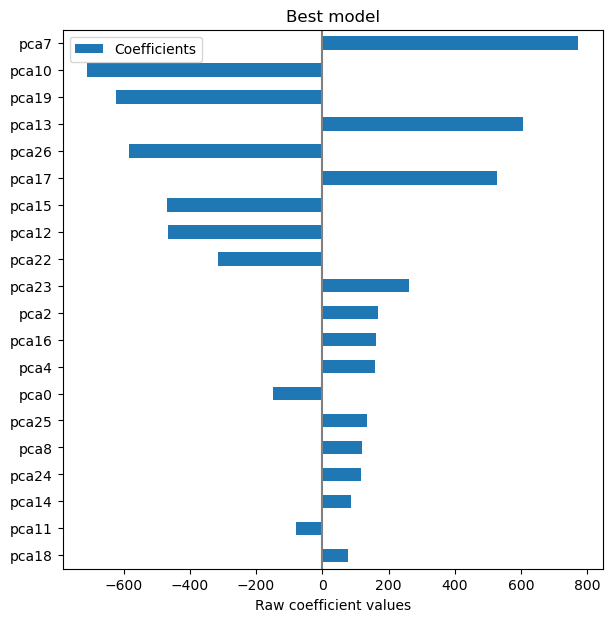

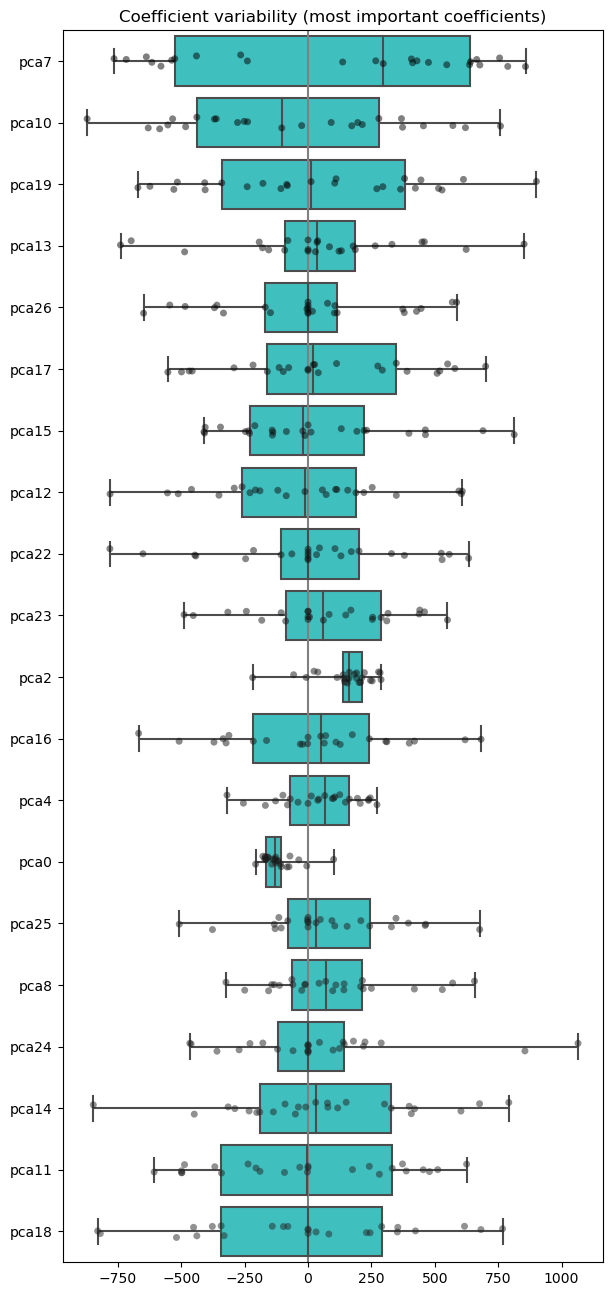

In [37]:
pipeline_exp4 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp4 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'dims': [
        {'reduce_dims__n_components': randint(1,30)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp4 = [flatten(params, parent_key=None) for params in dict_product(params_exp4)]
run_exp("middle_scale_select_reduce_linear", y_mid, pipeline_exp4, params_exp4, randomize=True, rs_iters=200, random_state=RS)

# Experiments - pole interior

## Experiment #1: Scaling + linear model

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -821.36 ± 241.83


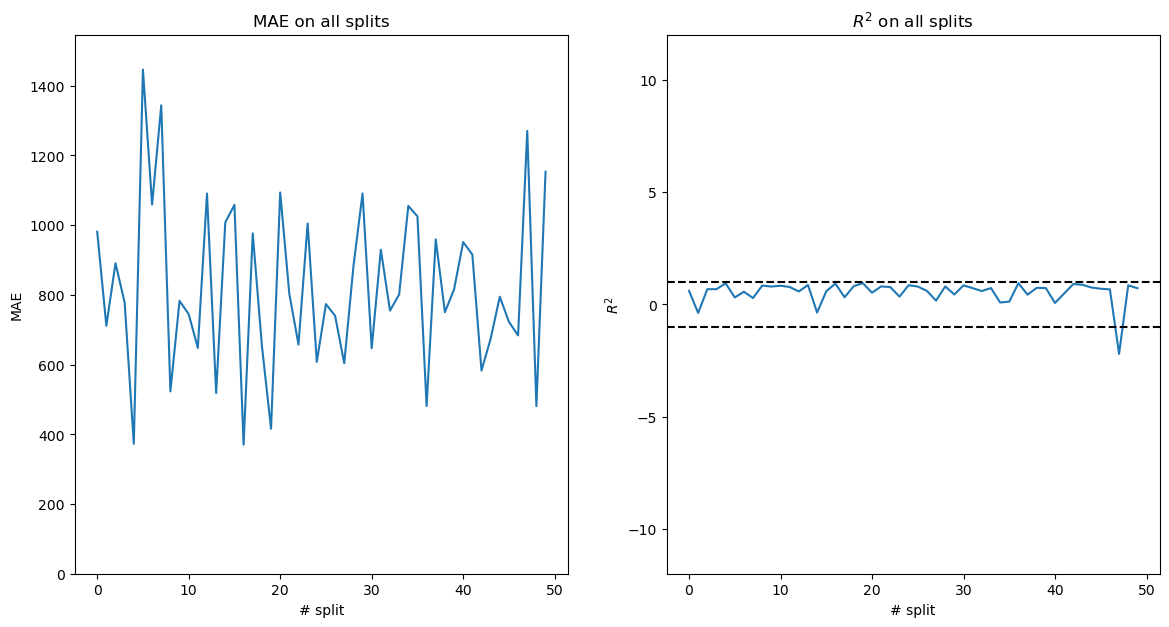

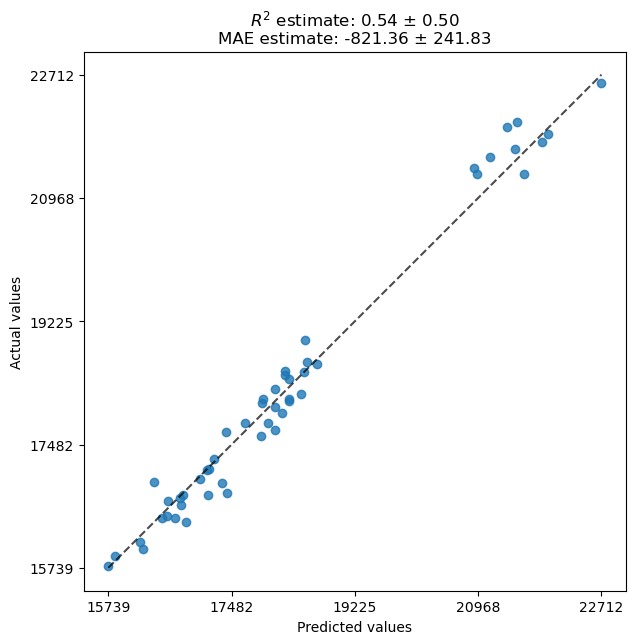

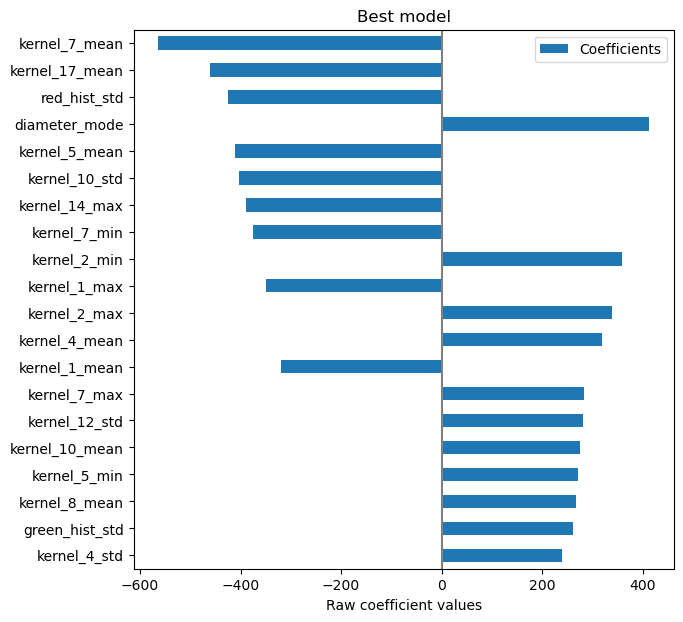

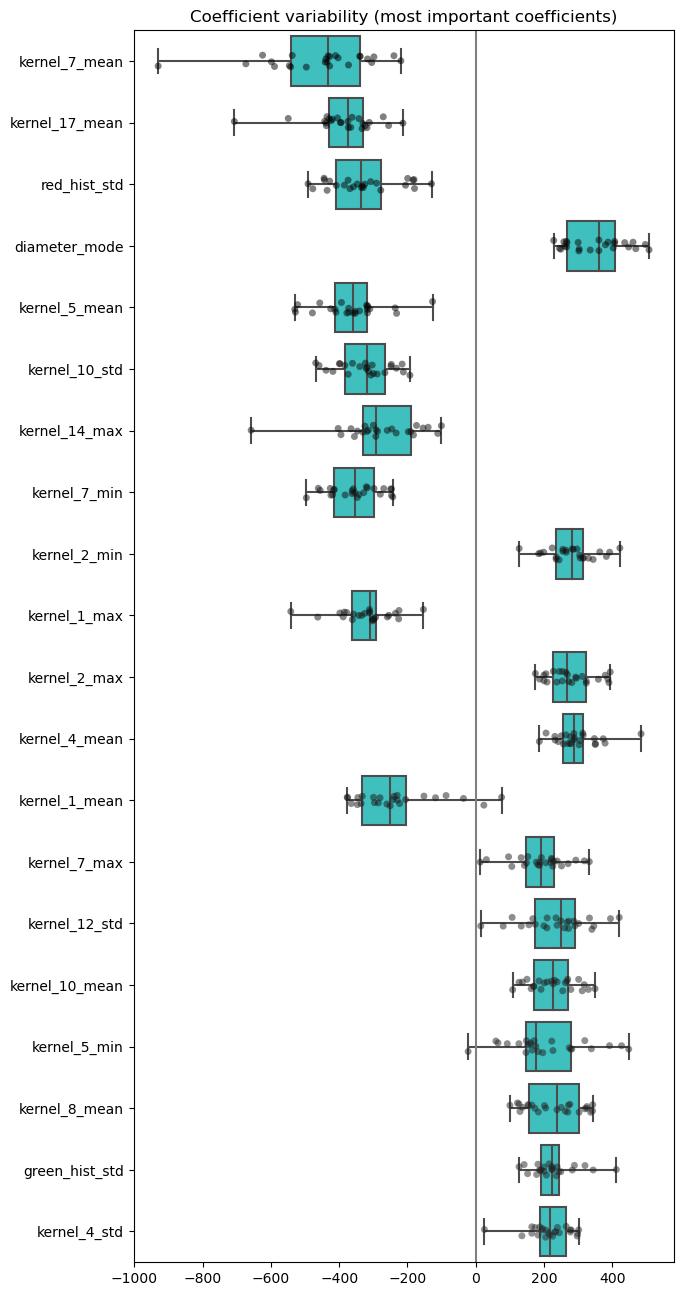

In [38]:
pipeline_exp1 = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])

params_exp1 = [
    {'model': [LinearRegression()]},
    {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("interior_scale_linear", y_int, pipeline_exp1, params_exp1, random_state=RS)

## Experiment #2: Scaling + dimensionality reduction + linear model

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dims', PCA(n_components=29)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -808.83 ± 238.69


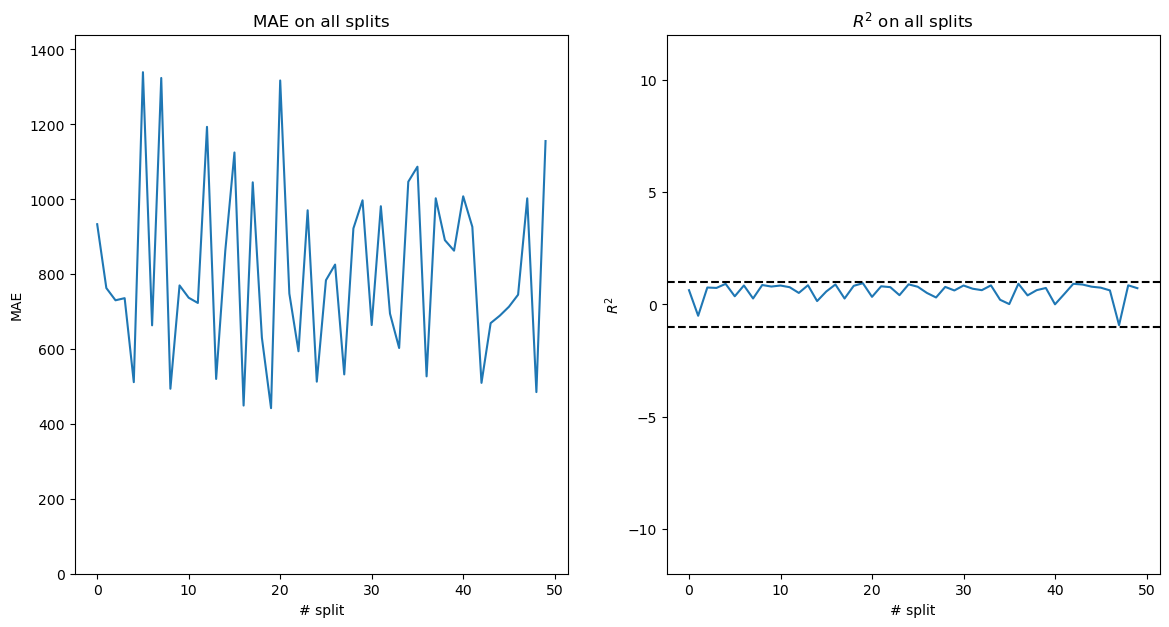

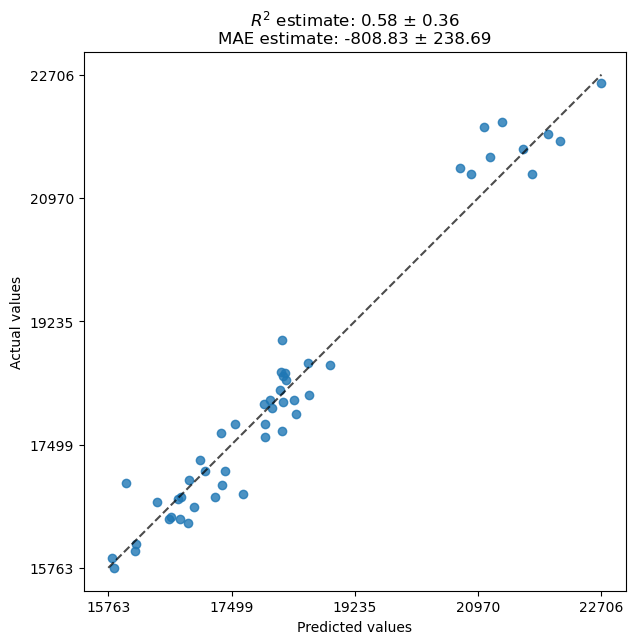

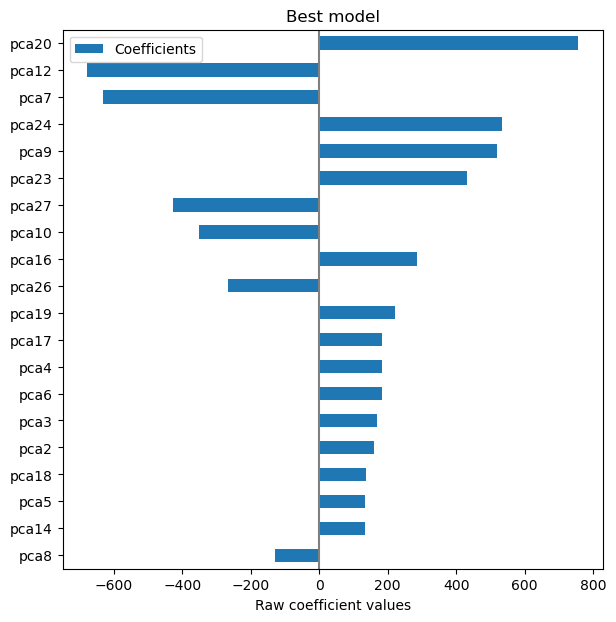

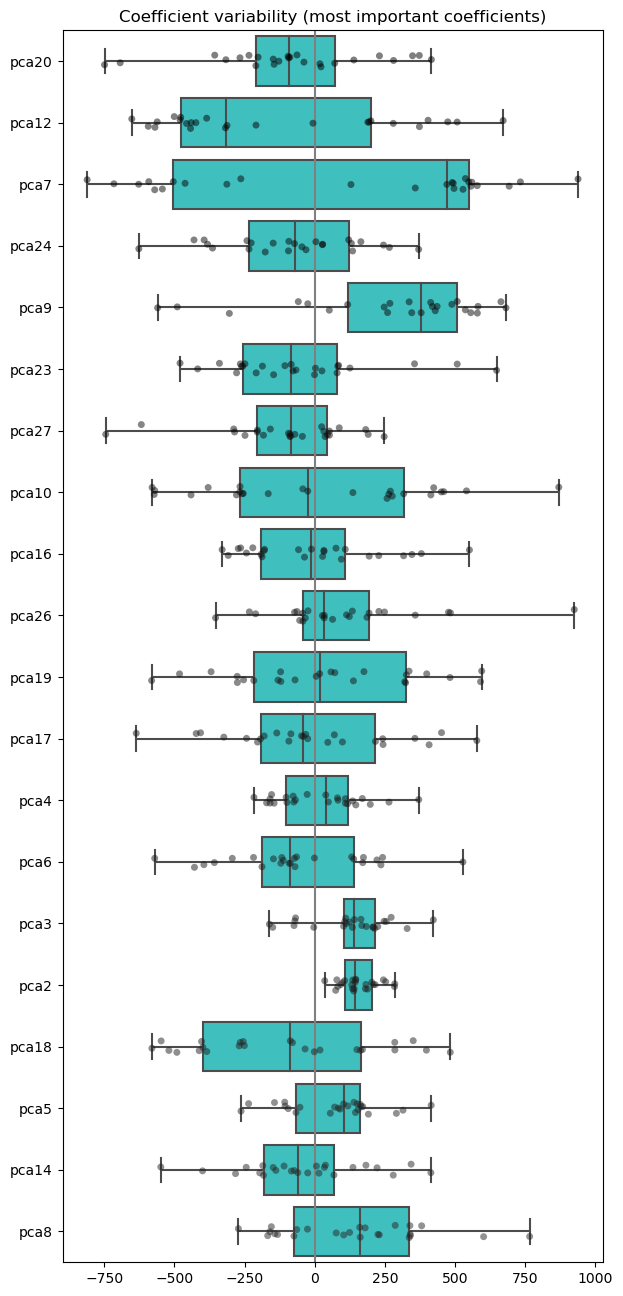

In [39]:
pipeline_exp2 = Pipeline([('scaler', StandardScaler()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp2 = [
    {'reduce_dims__n_components': randint(1,30), 'model': [LinearRegression()]},
    {'reduce_dims__n_components': randint(1,30), 'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'reduce_dims__n_components': randint(1,30), 'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'reduce_dims__n_components': randint(1,30), 'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("interior_scale_reduce_linear", y_int, pipeline_exp2, params_exp2, randomize=True, random_state=RS)

In this case, the obtained model seems to perform slightly better than the previous one. The estimated $R^2$ score has improved from 0.29 to 0.35, and the MAE has improved from 1114 to 1092. It is a small improvement, but a sign that dimensionality reduction might be good for this problem, even if model interpretability becomes harder this way.

However, by looking at the coefficient variability plot, it can be seen that coefficients vary much more wildly than in the previous setting, so the coefficients obtained by the model trained upon the dimensionality-reduced dataset might not be as reliable.

## Experiment #3: Scaling + feature selection + linear model

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 SelectKBest(k=74,
                             score_func=<function f_regression at 0x0000014FA6996C10>)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -886.74 ± 267.09


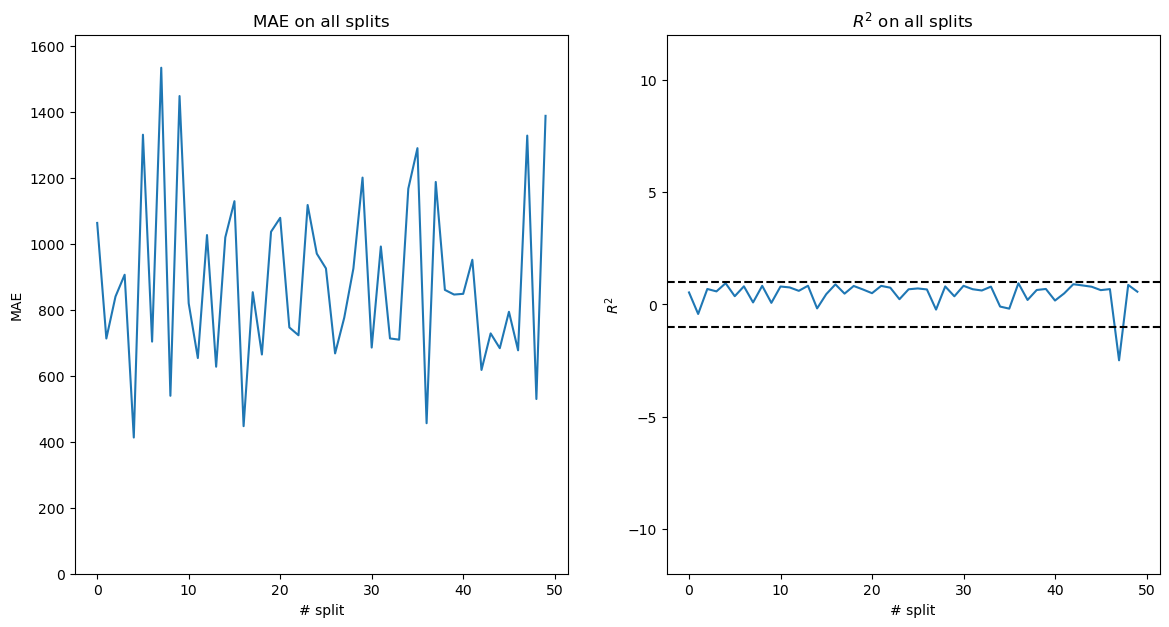

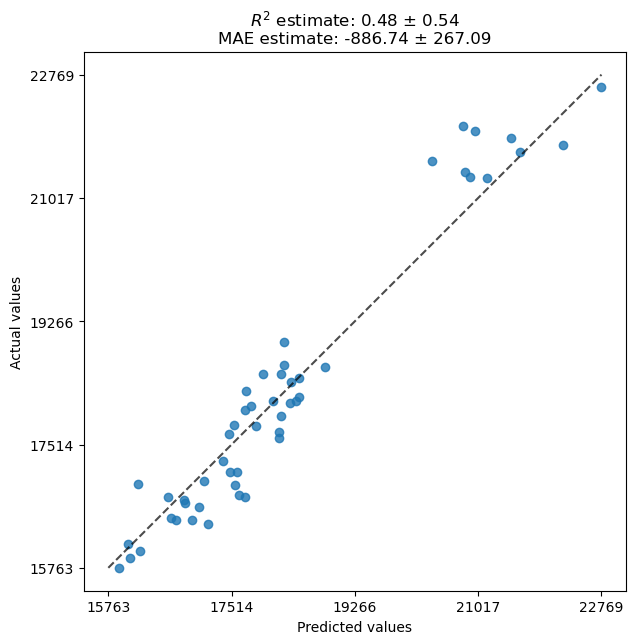

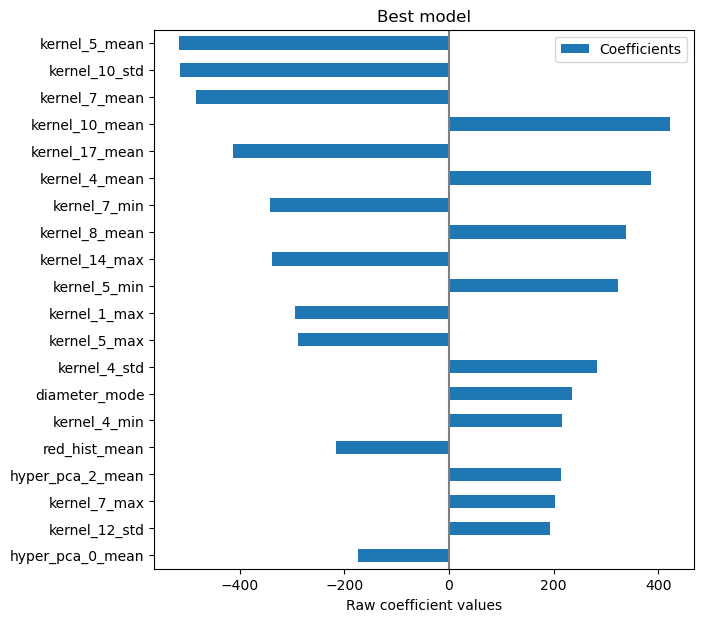

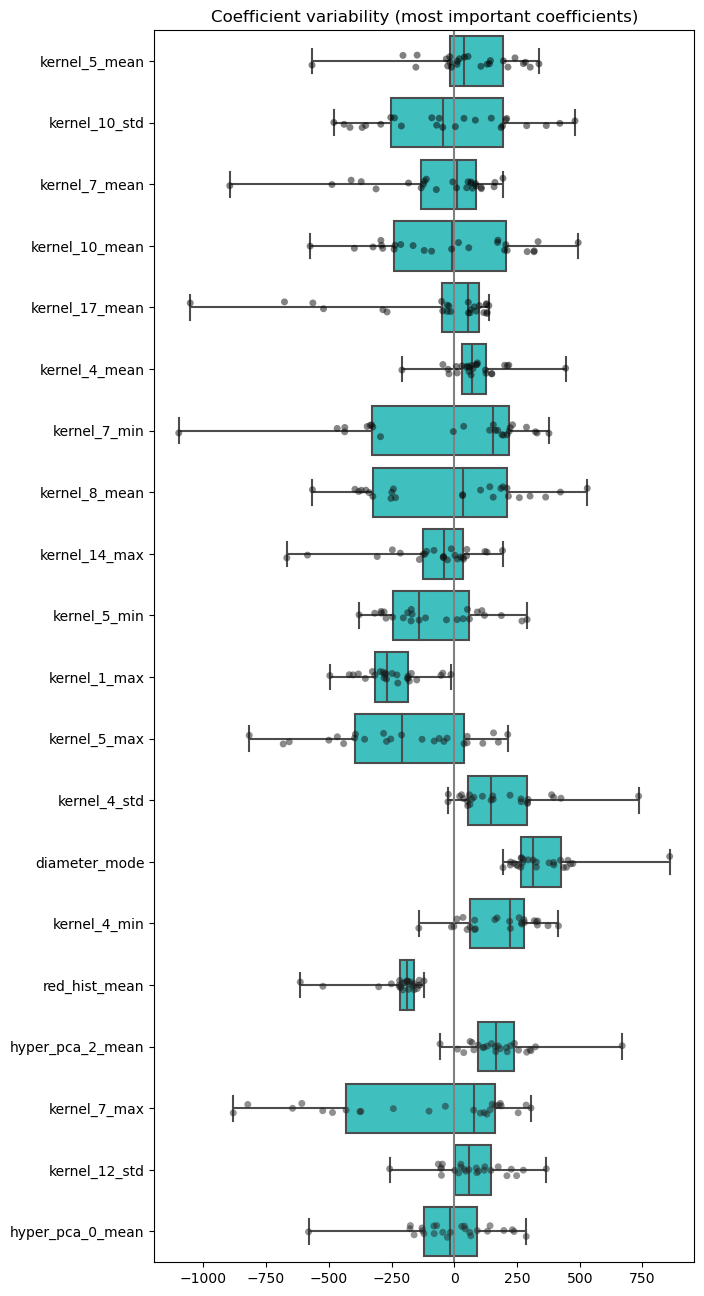

In [40]:
pipeline_exp3 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('model', LinearRegression())])

params_exp3 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp3 = [flatten(params, parent_key=None) for params in dict_product(params_exp3)]

run_exp("interior_scale_select_linear", y_int, pipeline_exp3, params_exp3, randomize=True, random_state=RS)

## Experiment #4: Scaling + feature selection + dimensionality reduction + linear model

Fitting 50 folds for each of 200 candidates, totalling 10000 fits


C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1850 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\pipeline.py", lin

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 RFE(estimator=LinearRegression(), n_features_to_select=62)),
                ('reduce_dims', PCA(n_components=26)),
                ('model',
                 LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=42))])
Mean absolute error of this model: -809.93 ± 218.72


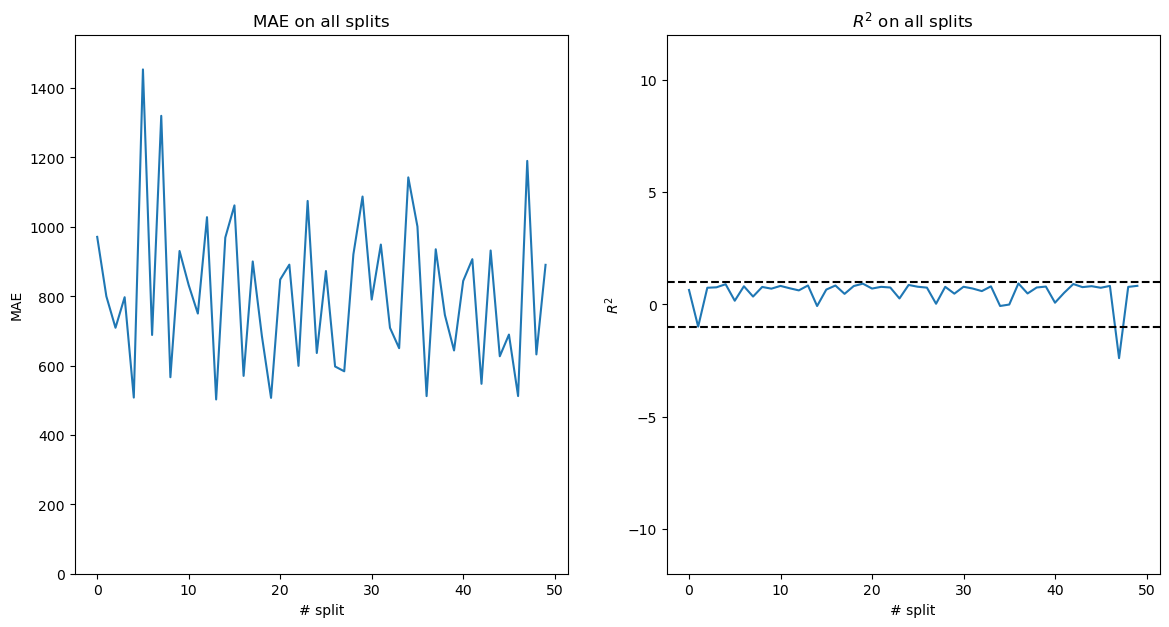

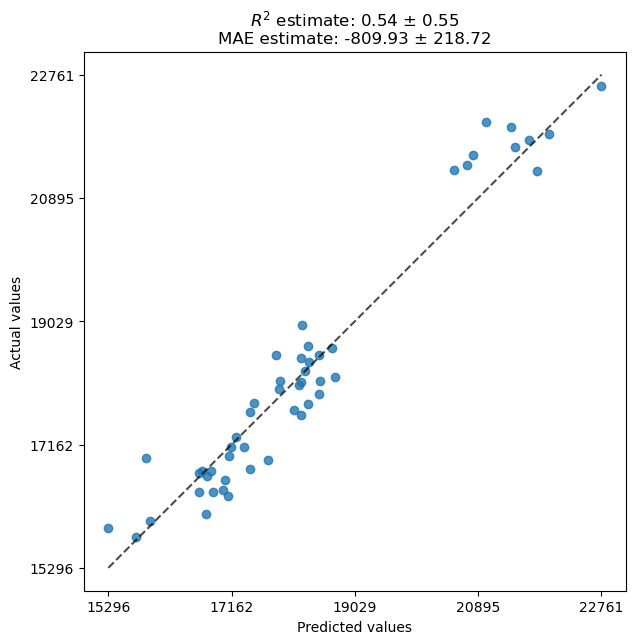

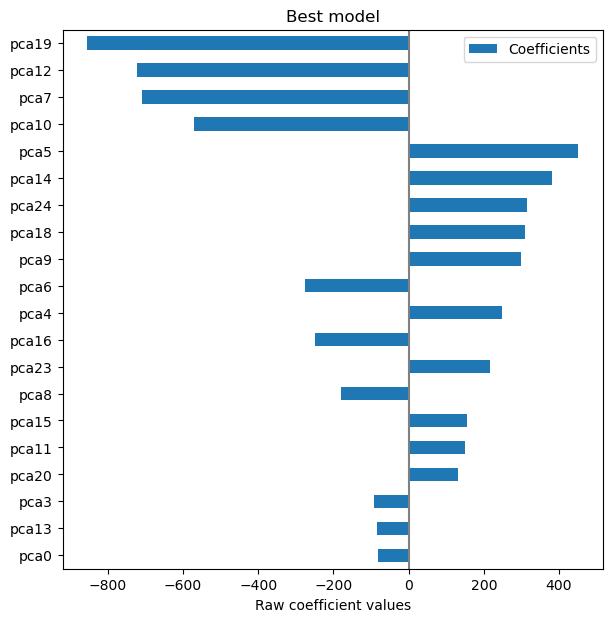

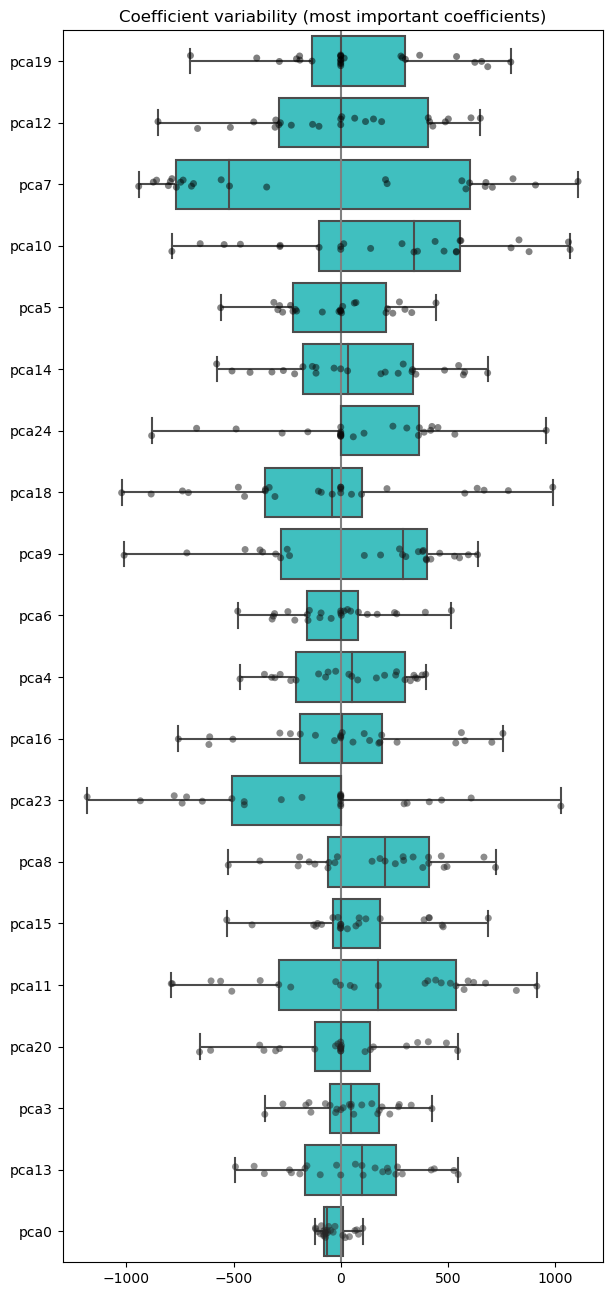

In [41]:
pipeline_exp4 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp4 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'dims': [
        {'reduce_dims__n_components': randint(1,30)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp4 = [flatten(params, parent_key=None) for params in dict_product(params_exp4)]
run_exp("interior_scale_select_reduce_linear", y_int, pipeline_exp4, params_exp4, randomize=True, rs_iters=200, random_state=RS)

# Experiments - surface depth

## Experiment #1: Scaling + linear model

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ElasticNetCV(cv=LeaveOneOut(), max_iter=10000,
                              random_state=42))])
Mean absolute error of this model: -0.04 ± 0.01


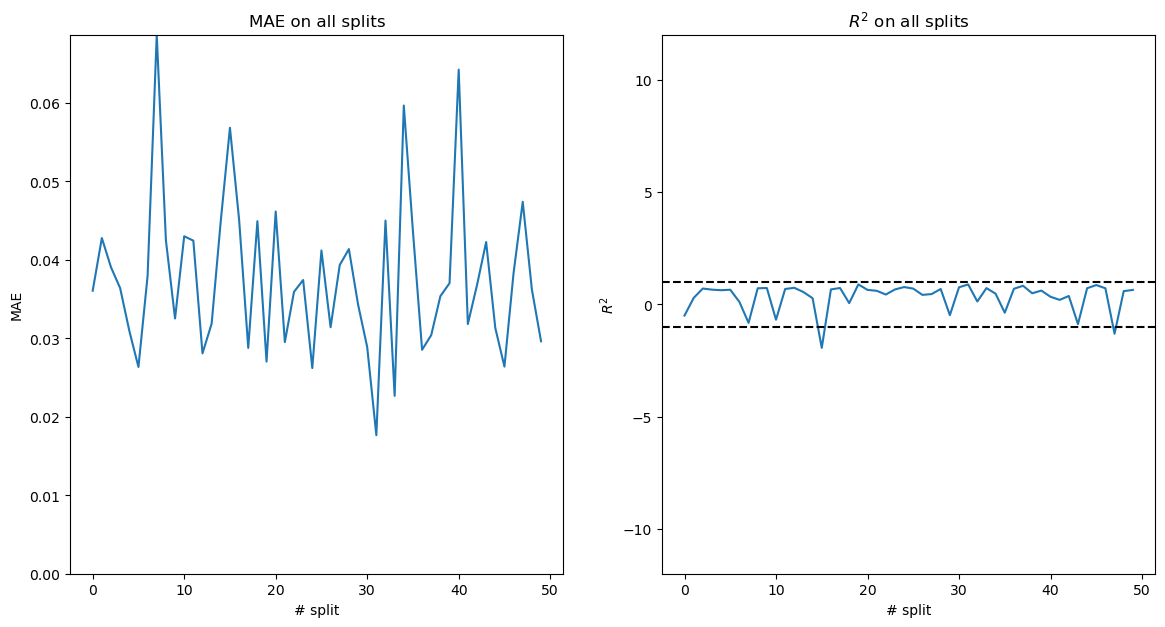

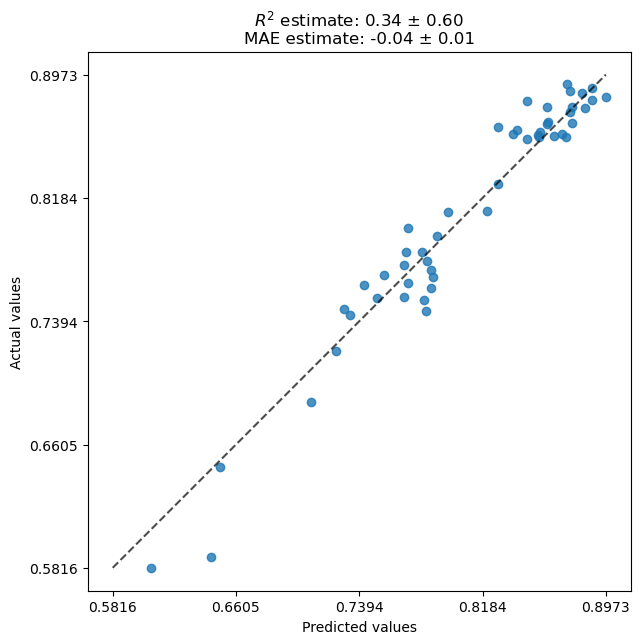

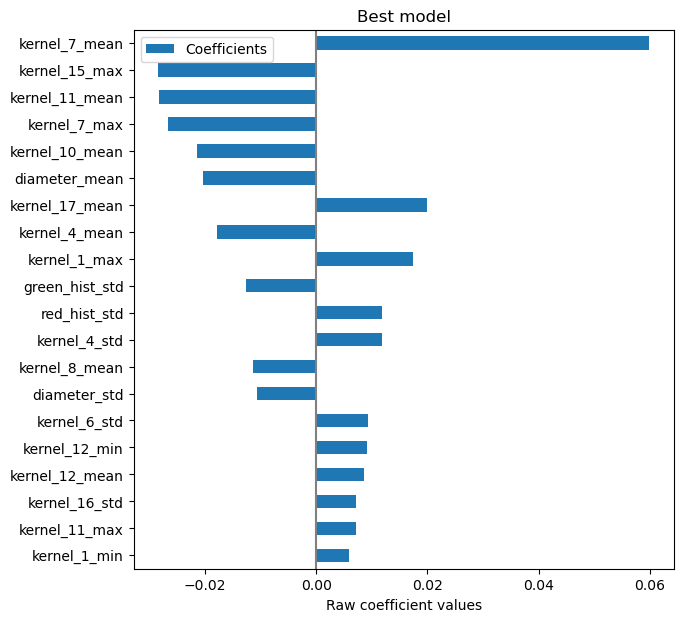

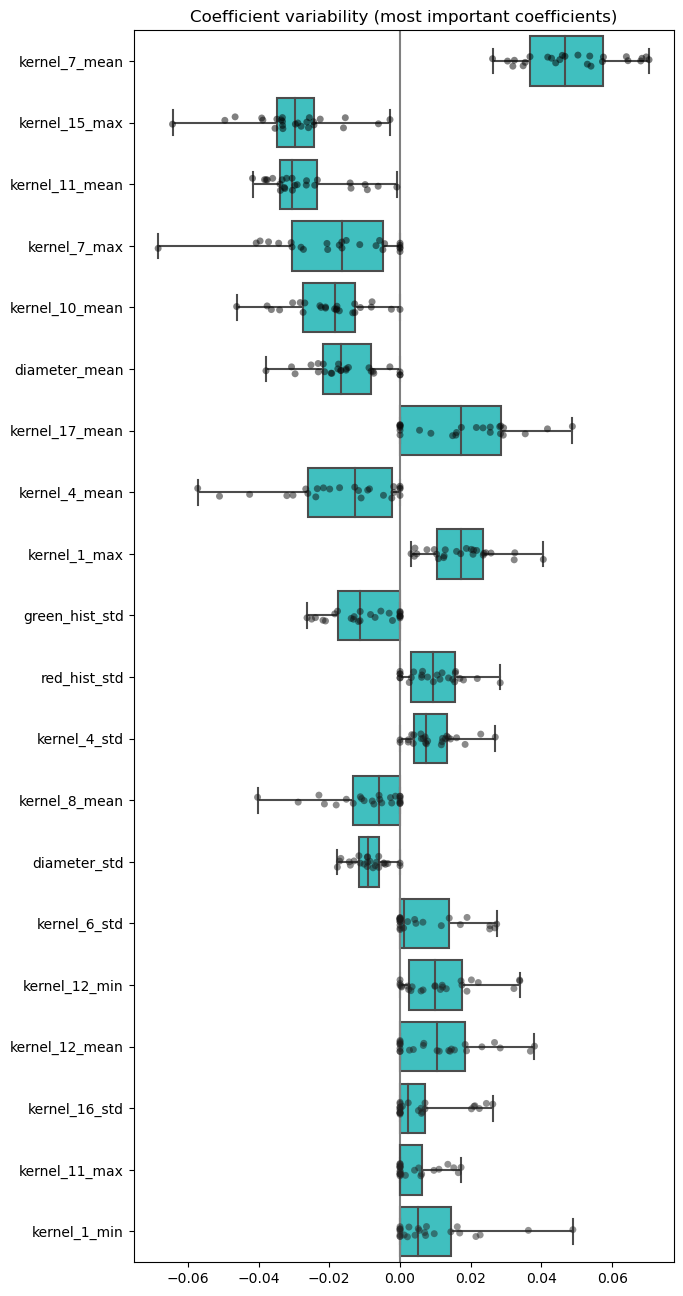

In [51]:
pipeline_exp1 = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])

params_exp1 = [
    {'model': [LinearRegression()]},
    {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("depth_scale_linear", y_sdepth, pipeline_exp1, params_exp1, random_state=RS, mae_plot_padding=False)

## Experiment #2: Scaling + dimensionality reduction + linear model

As the preliminary analysis has shown, this dataset has 89 predictor variables, but only 50 samples. This high dimensionality may lead to overfitting issues, and therefore it could be interesting to try different dimensionality reduction techniques.

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dims', PCA(n_components=24)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -0.04 ± 0.01


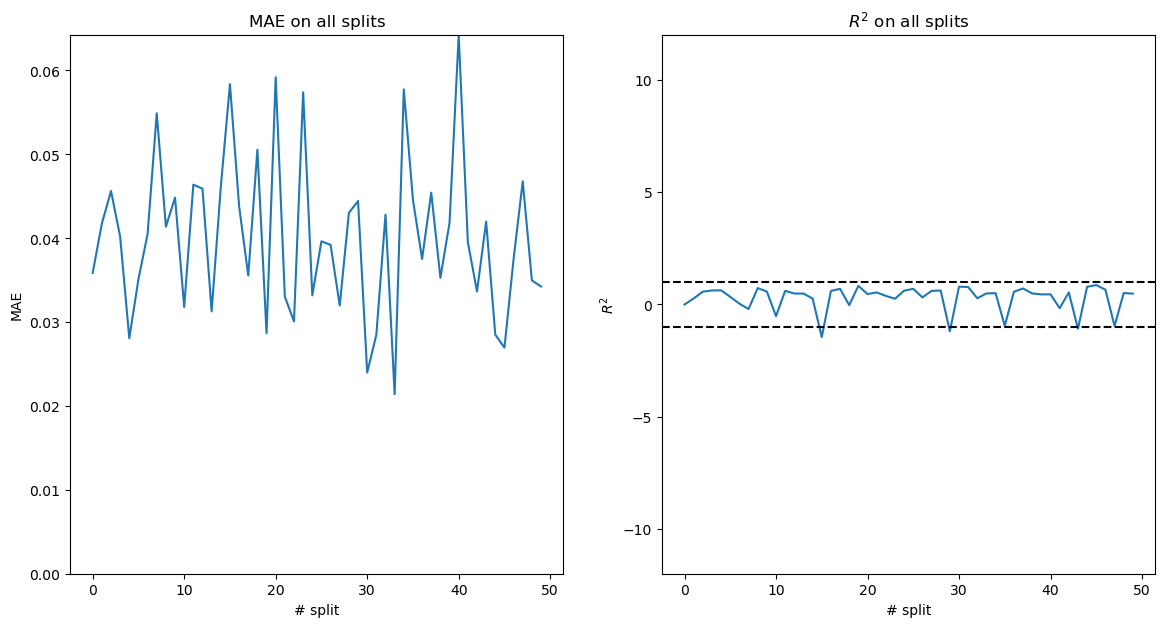

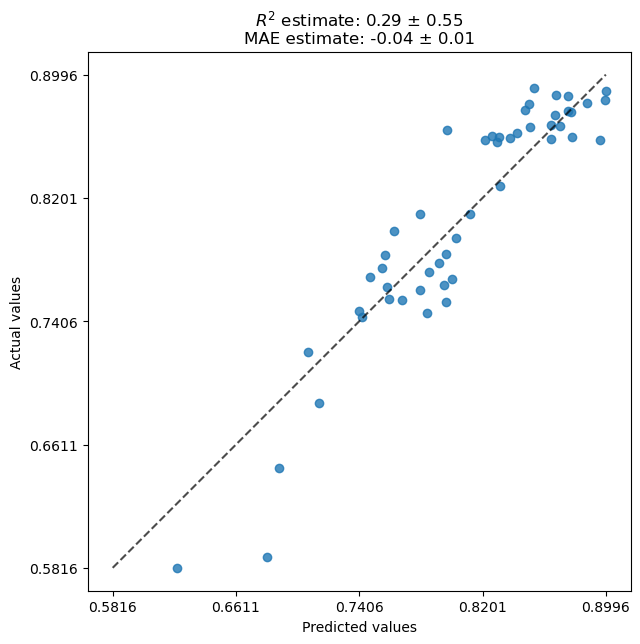

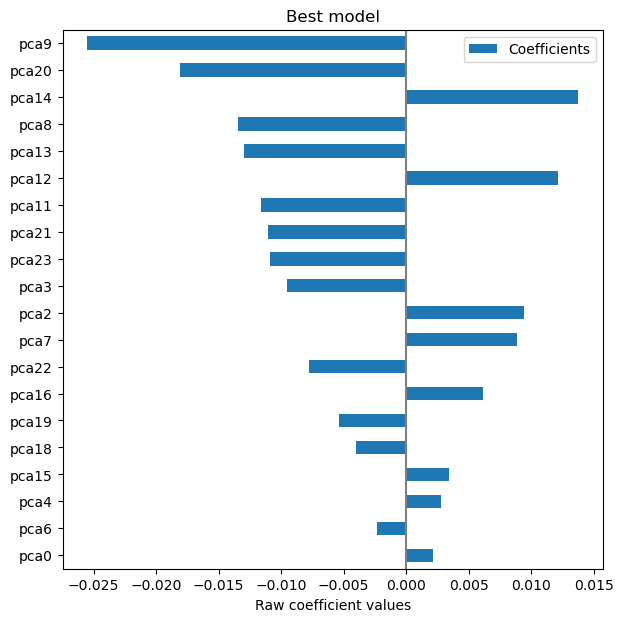

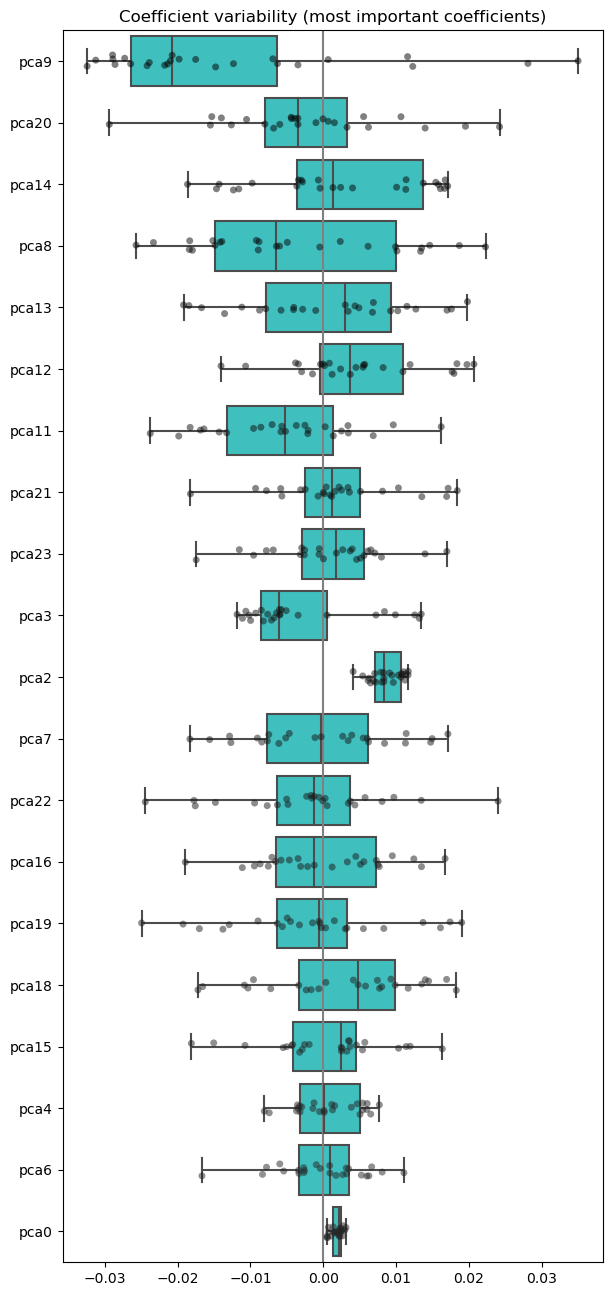

In [52]:
pipeline_exp2 = Pipeline([('scaler', StandardScaler()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp2 = [
    {'reduce_dims__n_components': randint(1,30), 'model': [LinearRegression()]},
    {'reduce_dims__n_components': randint(1,30), 'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
    {'reduce_dims__n_components': randint(1,30), 'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
    {'reduce_dims__n_components': randint(1,30), 'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
]

run_exp("depth_scale_reduce_linear", y_sdepth, pipeline_exp2, params_exp2, randomize=True, random_state=RS, mae_plot_padding=False)

## Experiment #3: Scaling + feature selection + linear model

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 RFE(estimator=LinearRegression(), n_features_to_select=72)),
                ('model',
                 LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=42))])
Mean absolute error of this model: -0.04 ± 0.01


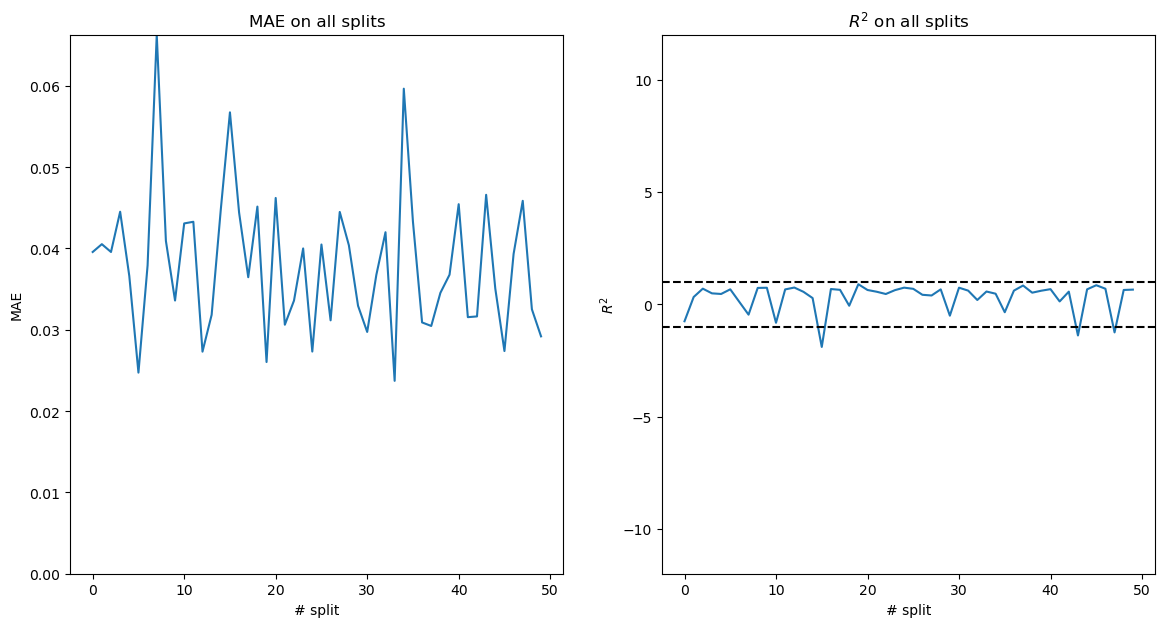

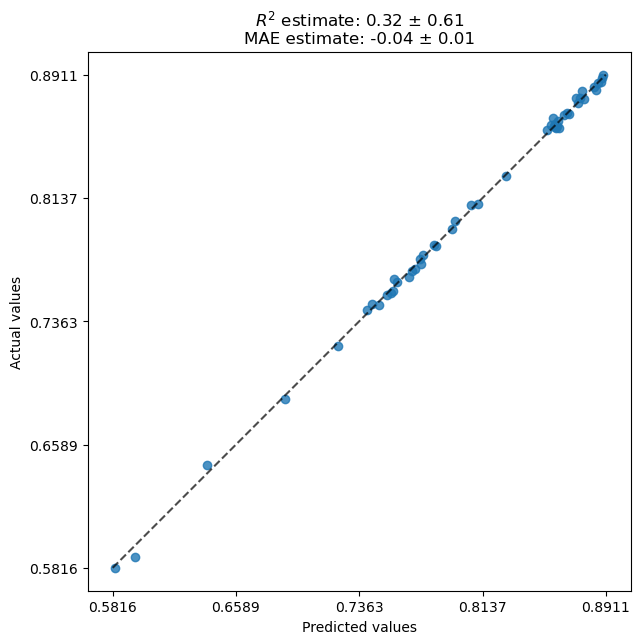

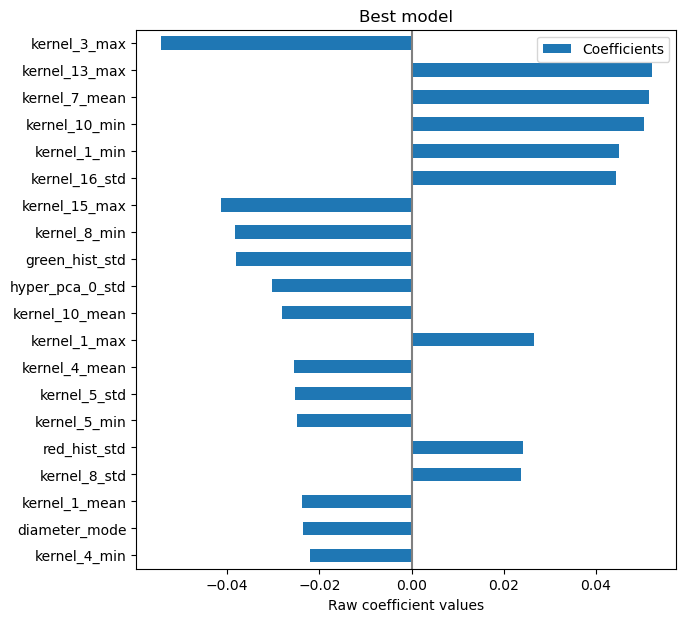

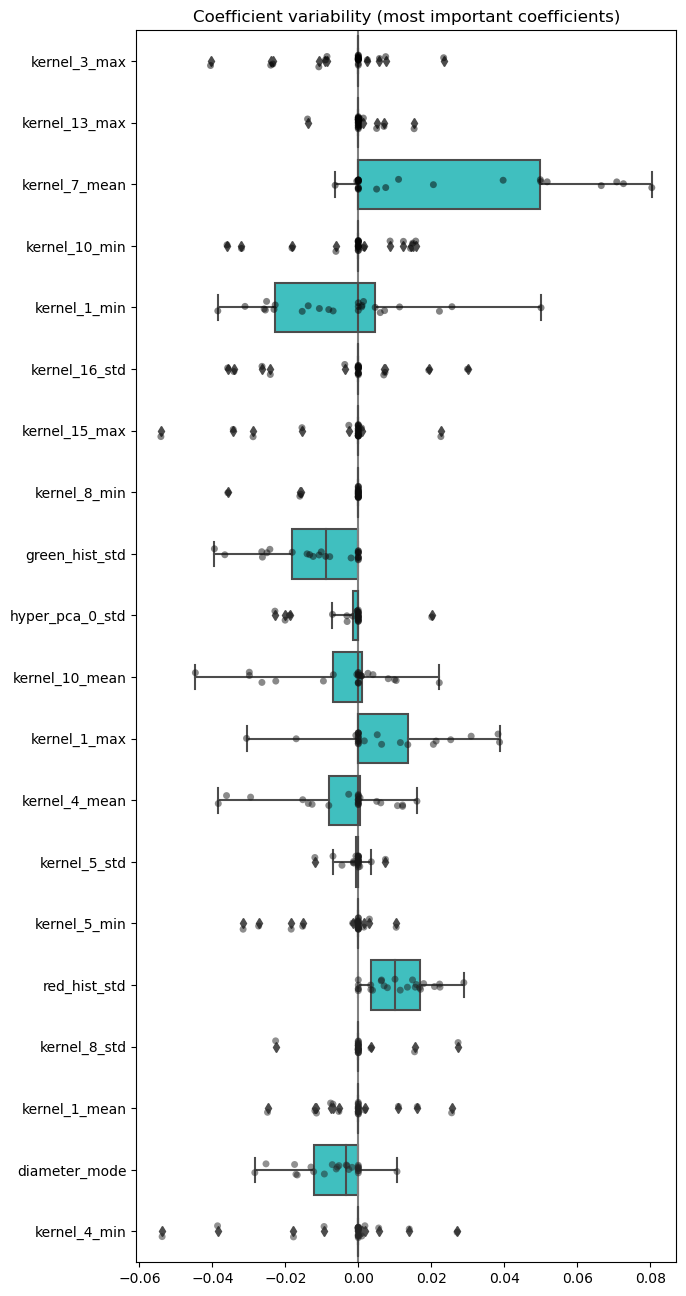

In [53]:
pipeline_exp3 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('model', LinearRegression())])

params_exp3 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp3 = [flatten(params, parent_key=None) for params in dict_product(params_exp3)]

run_exp("depth_scale_select_linear", y_sdepth, pipeline_exp3, params_exp3, randomize=True, random_state=RS, mae_plot_padding=False)

## Experiment #4: Scaling + feature selection + dimensionality reduction + linear model

Fitting 50 folds for each of 200 candidates, totalling 10000 fits


C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1850 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ext-lugo\Anaconda3\envs\pole-analysis\lib\site-packages\sklearn\pipeline.py", lin

The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('select_features',
                 RFE(estimator=LinearRegression(), n_features_to_select=77)),
                ('reduce_dims', PCA(n_components=25)),
                ('model',
                 RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0)))])
Mean absolute error of this model: -0.04 ± 0.01


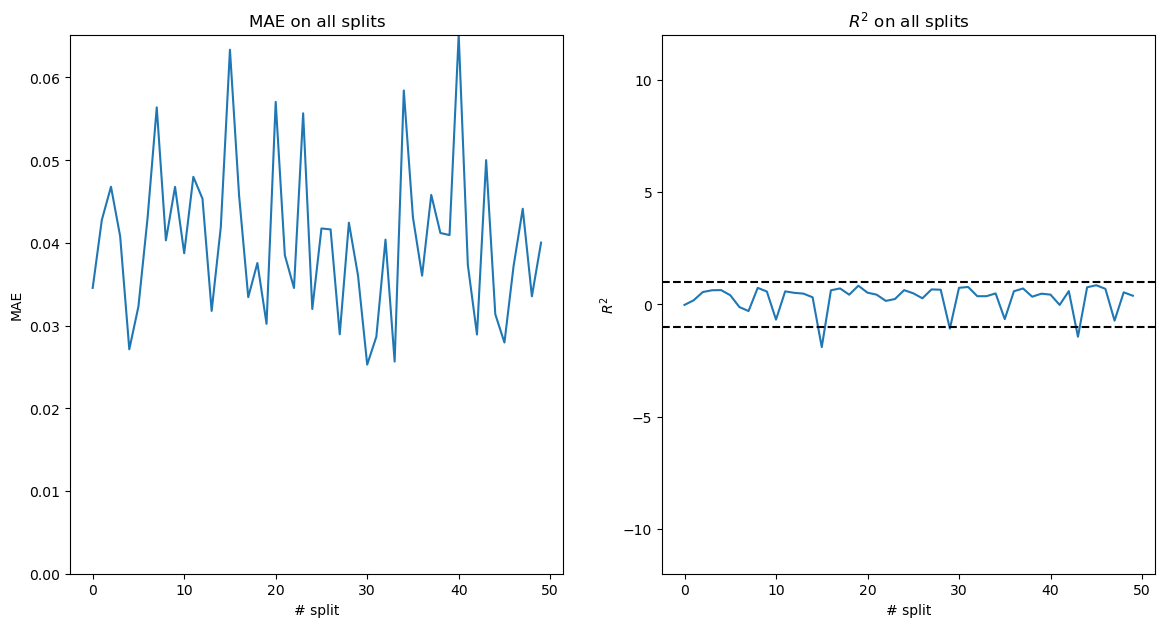

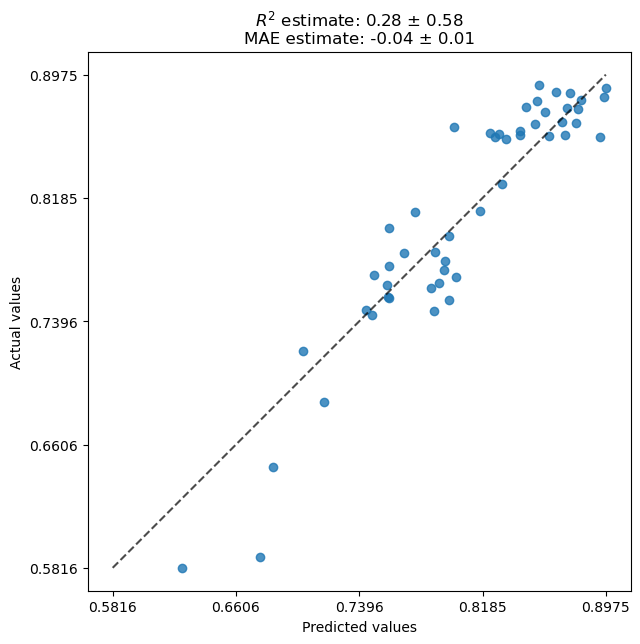

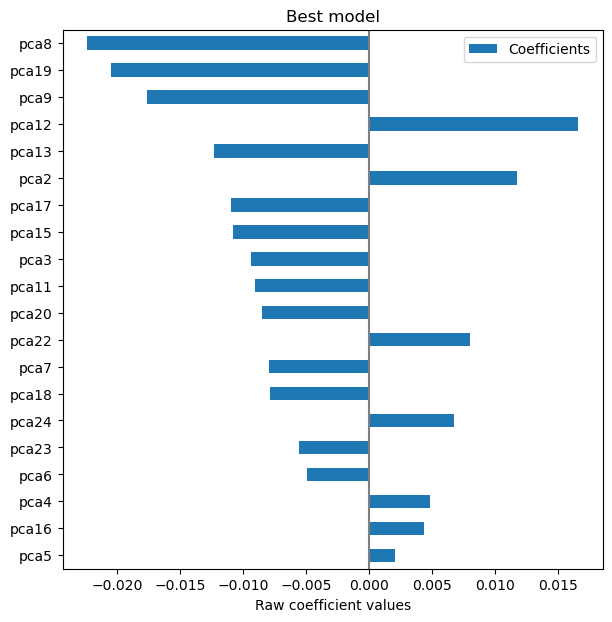

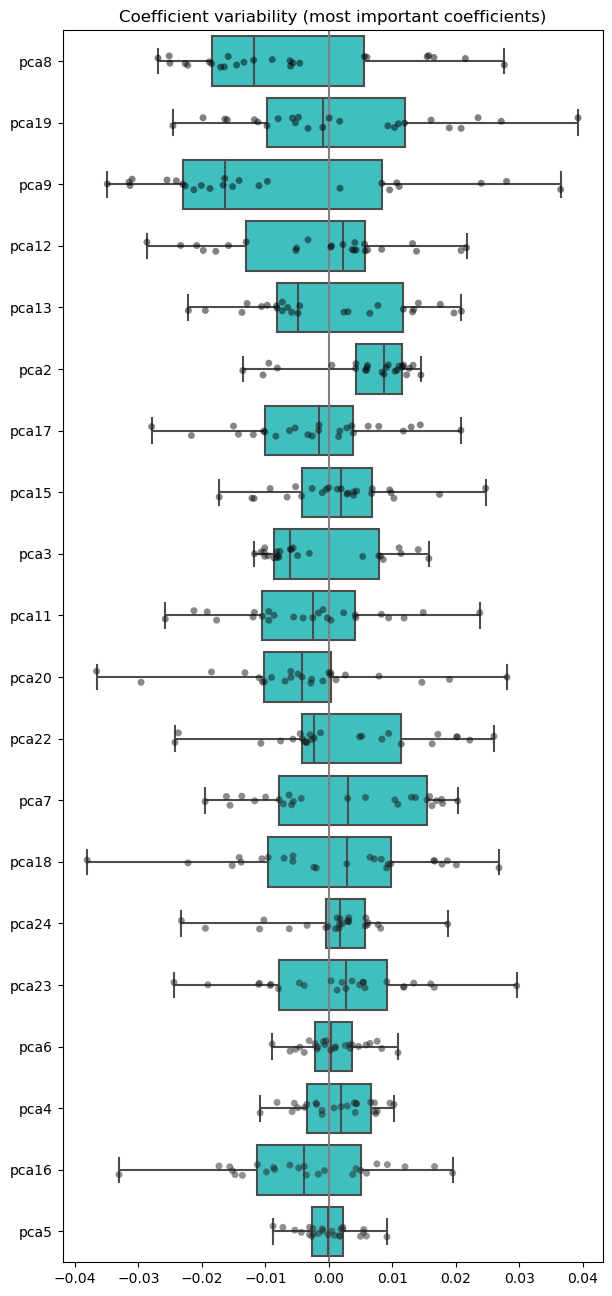

In [54]:
pipeline_exp4 = Pipeline([('scaler', StandardScaler()), ('select_features', SelectKBest()), ('reduce_dims', PCA()), ('model', LinearRegression())])

params_exp4 = {
    'feats': [
        {'select_features': [SelectKBest(score_func=f_regression)], 'select_features__k': randint(1,80)},
        {'select_features': [RFE(LinearRegression())], 'select_features__n_features_to_select': randint(1,80)}
    ],
    'dims': [
        {'reduce_dims__n_components': randint(1,30)}
    ],
    'regressor': [
        {'model': [LinearRegression()]},
        {'model': [RidgeCV(alphas=(0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0))]},
        {'model': [LassoCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]},
        {'model': [ElasticNetCV(cv=LeaveOneOut(), max_iter=10000, random_state=RS)]}
    ]
}

params_exp4 = [flatten(params, parent_key=None) for params in dict_product(params_exp4)]
run_exp("depth_scale_select_reduce_linear", y_sdepth, pipeline_exp4, params_exp4, randomize=True, rs_iters=200, random_state=RS, mae_plot_padding=False)